### Imported Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import lightgbm as lgbm
import matplotlib
import multiprocessing
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.options.display.max_rows = 300

### Feature Extraction Functions

In [40]:
beta = pd.read_feather("beta/betas_condensed.fth")
spread_dom = pd.read_csv("all_times.csv").drop(["beta"],axis=1)
DENORM = pd.read_csv("denormalize_multipliers.csv")

def mad(data):
    return np.mean(np.absolute(data - np.mean(data)))

def import_beta(df):
    global beta
    global spread_dom
    
    df = pd.merge(df, beta, how="left")
    df = pd.merge(df, spread_dom, how="left")
    return df
    
def compute_wap(df):
    return (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) \
          /(df['bid_size1'] + df['ask_size1'])

def compute_wap2(df):
    return (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) \
           /(df['bid_size2'] + df['ask_size2'])

def compute_dom(df):
    dom = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            + (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])
    return dom

def compute_dom_diff(df):
    dom_diff = abs((df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            - (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2']))
    return dom_diff

def fill_seconds(df):
    df = df.reset_index(drop=True)
    index_range = pd.Index(range(600), name='seconds_in_bucket')
    df = df.set_index('seconds_in_bucket').reindex(index_range)
    
    # Forward fill & back fill seconds
    df = df.ffill().reset_index()
    return df.bfill().iloc[:600]

def beta_encoding(df):
    beta1 = np.repeat(np.nan, df.shape[0])
    beta2 = np.repeat(np.nan, df.shape[0])
    kf = KFold(n_splits = 112, shuffle=True,random_state = 0)
    for idx_1, idx_2 in kf.split(df):
        bmean1 = df.iloc[idx_1].groupby('stock_id')['beta'].mean()
        bmean2 = df.iloc[idx_1].groupby('stock_id')['beta2'].mean()
        beta1[idx_2] = df['stock_id'].iloc[idx_2].map(bmean1)
        beta2[idx_2] = df['stock_id'].iloc[idx_2].map(bmean2)
        
    df['encode_mean_beta'] = beta1
    df['encode_mean_beta2'] = beta2
    
    return df.drop(['beta','beta2'], axis=1)

def import_clusters(df):
    reduc_feats_label = pd.read_csv("pca10_clusts.csv").iloc[:,1:]
    bds_cluster_label = pd.read_csv("cluster_labels.csv").iloc[:,1:]
    som_cluster_label = pd.read_csv("SOM_clusters.csv")
    #feature_leakage = pd.read_csv("feats_to_cluster.csv").iloc[:,1:]
    
    df = df.merge(reduc_feats_label, how="left")
    df = df.merge(bds_cluster_label, how="left")
    df = df.merge(som_cluster_label, how="left")
    #df = df.merge(feature_leakage, how="left")
    
    return df.reset_index(drop=True)

def remove_clusters(df, n=13):
    if "bds_gmm6" in df.columns:
        return df.drop(df.columns[-n:], axis=1)
    return df

def target_encoding(df):
    tenc = np.repeat(np.nan, df.shape[0])
    senc = np.repeat(np.nan, df.shape[0])
    denc = np.repeat(np.nan, df.shape[0])
    tencs = np.repeat(np.nan, df.shape[0])
    sencs = np.repeat(np.nan, df.shape[0])
    dencs = np.repeat(np.nan, df.shape[0])
    kf = KFold(n_splits = 112, shuffle=True,random_state = 0)
    for idx_1, idx_2 in kf.split(df):
        tmean = df.iloc[idx_1].groupby('stock_id')['target_realized_volatility'].mean()
        smean = df.iloc[idx_1].groupby('stock_id')['spread'].mean()
        dmean = df.iloc[idx_1].groupby('stock_id')['dom'].mean()
        tmeans = df.iloc[idx_1].groupby('stock_id')['target_realized_volatility'].std()
        smeans = df.iloc[idx_1].groupby('stock_id')['spread'].std()
        dmeans = df.iloc[idx_1].groupby('stock_id')['dom'].std()
        tenc[idx_2] = df['stock_id'].iloc[idx_2].map(tmean)
        senc[idx_2] = df['stock_id'].iloc[idx_2].map(smean)
        denc[idx_2] = df['stock_id'].iloc[idx_2].map(dmean)
        tencs[idx_2] = df['stock_id'].iloc[idx_2].map(tmeans)
        sencs[idx_2] = df['stock_id'].iloc[idx_2].map(smeans)
        dencs[idx_2] = df['stock_id'].iloc[idx_2].map(dmeans)
    df['target_mean_enc'] = tenc
    df['spread_mean_enc'] = senc
    df['dom_mean_enc'] = denc
    df['target_std_enc'] = tencs
    df['spread_std_enc'] = sencs
    df['dom_std_enc'] = dencs
    
    return df.drop(['dom','spread'], axis=1)

def generate_feature_seconds(features, df, feats, seconds=[300], overlap=1):
    if overlap:
        for second in seconds:
            res = pd.DataFrame(
                df.query(f'{seconds[0]-second} <= seconds_in_bucket < {seconds[0]}')
                .groupby(['time_id']).agg(feats)
            ).reset_index()
            res.columns = ['_'.join(feat).rstrip('_') for feat in res.columns]
            res = res.add_suffix('_' + str(second))
            features = pd.merge(
                features, res, 
                how='left', 
                left_on='time_id', 
                right_on=f'time_id_{second}'
            )
            features = features.drop([f'time_id_{second}'], axis=1)  
    else:
        for i, second in enumerate(seconds):
            last_second = 0 if not i else seconds[i-1]
            res = pd.DataFrame(
                df.query(f'{last_second} <= seconds_in_bucket < {second}')
                .groupby(['time_id']).agg(feats)
            ).reset_index()
            res.columns = ['_'.join(feat).rstrip('_') for feat in res.columns]
            res = res.add_suffix('_' + str(second))
            features = pd.merge(
                features, res, 
                how='left', 
                left_on='time_id', 
                right_on=f'time_id_{second}'
            )
            features = features.drop([f'time_id_{second}'], axis=1)
    return features

def generate_target(df, target, second=300):
    features = pd.DataFrame(
        df.query(f'seconds_in_bucket >= {second}')
        .groupby(['time_id']).agg(target)
    ).reset_index()
    
    features.columns = ['_'.join(feat).rstrip('_') for feat in features.columns]
    return features

def calc_slope(df):
    v0 = (df['bid_size1']+df['ask_size1'])/2
    p0 = (df['bid_price1']+df['ask_price1'])/2
    slope_bid = ((df['bid_size1']/v0)-1)/abs((df['bid_price1']/p0)-1)+(
                (df['bid_size2']/df['bid_size1'])-1)/abs((df['bid_price2']/df['bid_price1'])-1)
    slope_ask = ((df['ask_size1']/v0)-1)/abs((df['ask_price1']/p0)-1)+(
                (df['ask_size2']/df['ask_size1'])-1)/abs((df['ask_price2']/df['ask_price1'])-1)
    return (slope_bid+slope_ask)/2, abs(slope_bid-slope_ask)


def calc_dispersion(df):
    bspread = df['bid_diff']
    aspread = df['ask_diff']
    bmid = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price1']
    bmid2 = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price2']
    amid = df['ask_price1'] - (df['bid_price1'] + df['ask_price1'])/2
    amid2 = df['ask_price2'] - (df['bid_price1'] + df['ask_price1'])/2
    bdisp = (df['bid_size1']*bmid + df['bid_size2']*bspread)/(df['bid_size1']+df['bid_size2'])
    bdisp2 = (df['bid_size1']*bmid + df['bid_size2']*bmid2)/(df['bid_size1']+df['bid_size2'])
    adisp = (df['ask_size1']*amid + df['ask_size2']*aspread)/(df['ask_size1']+df['ask_size2'])      
    adisp2 = (df['ask_size1']*amid + df['ask_size2']*amid2)/(df['ask_size1']+df['ask_size2'])
    return (bdisp + adisp)/2, (bdisp2 + adisp2)/2

def calc_price_impact(df):
    ask = (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])/(df['ask_size1']+df['ask_size2'])
    bid = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2'])/(df['bid_size1']+df['bid_size2'])
    return (df['ask_price1'] - ask)/df['ask_price1'], (df['bid_price1'] - bid)/df['bid_price1']


def calc_ofi(df):
    a = df['bid_size1']*np.where(df['bid_price1'].diff()>=0,1,0)
    b = df['bid_size1'].shift()*np.where(df['bid_price1'].diff()<=0,1,0)
    c = df['ask_size1']*np.where(df['ask_price1'].diff()<=0,1,0)
    d = df['ask_size1'].shift()*np.where(df['ask_price1'].diff()>=0,1,0)
    return a - b - c + d

def calc_tt1(df):
    p1 = df['ask_price1'] * df['ask_size1'] + df['bid_price1'] * df['bid_size1']
    p2 = df['ask_price2'] * df['ask_size2'] + df['bid_price2'] * df['bid_size2']      
    return p2 - p1 

def log_returns(waps):
    return np.log(waps).diff() 

def realized_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2))

def weighted_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2)/log_returns.count())

def quarticity(s):
    return (s.count()/3) * np.sum(s**4)

def denormalize(df):
    global DENORM

    df = df.merge(DENORM, how="left")
    df['ask_price1'] *= df['multiplier']
    df['ask_price2'] *= df['multiplier']
    df['bid_price1'] *= df['multiplier']
    df['bid_price2'] *= df['multiplier']
    
    return df.drop(['multiplier'], axis=1)

### Generate Features for First 5 Minutes of Each Stock 

In [44]:
def generate_features(stock_id, df, extend, norm=False):
    
    if norm: df.groupby("time_id").apply(fill_seconds)
    
    # compute waps for first and second ask/bids 
    df['wap'] = compute_wap(df)
    df['wap2'] = compute_wap2(df)
    
    # compute log returns for realized volatility
    df['log_returns'] = df.groupby('time_id')['wap'].apply(log_returns)
    df['log_returns2'] = df.groupby('time_id')['wap2'].apply(log_returns)
    
    # compute difference in waps and price as feature
    df['wap_diff'] = abs(df['wap'] - df['wap2'])
    
    # price difference regularized
    df['price_diff'] = (df['ask_price1'] - df['bid_price1']) \
                        / ((df['ask_price1'] + df['bid_price1'])/2)
    df['price_diff2'] = (df['ask_price2'] - df['bid_price2']) \
                        / ((df['ask_price2'] + df['bid_price2'])/2)
    
    # difference between first and second bid/ask price
    df['bid_diff'] = df['bid_price1'] - df['bid_price2']
    df['ask_diff'] = df['ask_price1'] - df['ask_price2']
    
    # sum of first and second ask sizes and bid sizes
    df['bid_ask_volume'] = (df['ask_size1'] + df['ask_size2']) \
                        + (df['bid_size1'] + df['bid_size2'])
    
    # diff between ask sizes and bid sizes 
    df['bid_ask_volume_diff'] = abs((df['ask_size1'] + df['ask_size2']) \
                                - (df['bid_size1'] + df['bid_size2']))

    # depth of market and difference
    df['dom'] = compute_dom(df)
    df['dom_diff'] = compute_dom_diff(df)
    df['dom_imbalance'] = abs(df['dom'] - df['dom_diff'])
    
    # bid ask spread from lecture/lab
    df["bid_ask_spread1"] = df['ask_price1'] / df['bid_price1'] - 1
    df["bid_ask_spread2"] = df['ask_price2'] / df['bid_price2'] - 1
    df['bid_ask_spread3'] = abs(df['bid_diff'] - df['ask_diff'])
    
    df["slope"], _ = calc_slope(df)
    df["dispersion"], _ = calc_dispersion(df)
    df["price_impact"], _ = calc_price_impact(df)
    df["ofi"] = calc_ofi(df)
    df["turn_over"] = calc_tt1(df)   
    
    df['target'] =  df.groupby('time_id')['wap'].apply(log_returns)
    
    target_dict = {'target':[realized_volatility]}
    feature_dict = {
        'wap':[np.mean, np.std],#, mad, np.max, np.sum],
        'wap2':[np.mean, np.std],#, mad, np.max, np.sum],
        'log_returns':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean],# np.std, np.max],
        'log_returns2':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean],# np.std, np.max],
        'wap_diff':[np.std, np.max],#, mad, np.max, np.sum],
        'price_diff':[np.max, np.std], #np.max, np.sum],#, mad, np.max, np.sum],
        'price_diff2':[np.max, np.std],#, np.max, np.sum],#, mad, np.max, np.sum],
        'bid_diff':[np.max, np.std],#, np.max, np.sum],#, mad, np.max, np.sum],
        'ask_diff':[np.max, np.std],#, np.max, np.sum],#, mad, np.max, np.sum],
        'bid_ask_volume':[np.mean, np.std, np.max],#, np.sum],#, mad, np.max, np.sum],
        'bid_ask_volume_diff':[np.mean, np.max],#, mad, np.max, np.sum],
        'dom':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'dom_diff':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'dom_imbalance':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'bid_ask_spread1':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread2':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread3':[np.mean, np.std],#, mad, np.max, np.sum],
        'slope':[np.mean, np.max, np.std],#, mad, np.max, np.sum],
        'dispersion':[np.mean, np.max],#, mad, np.max, np.sum],
        'price_impact':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'ofi':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'turn_over':[np.mean, np.std, np.max]#, mad, np.max, np.sum],
    }
    
    # target realized volatility for next 300 second (5 min window in time_id)
    feature = generate_target(
        df, target=target_dict, 
        second=900 if extend else 300  # target volatility is for next 300 second (no overlap)
    )
    
    # obtain features over entire 5 mins or last 2.5 mins..
    
    feature = generate_feature_seconds(
        feature, df, 
        feats=feature_dict, 
        seconds=[900, 600, 300, 150, 75] if extend else [300, 150, 75],  # features generated for each second interval (different widths)
        overlap=1,
    )
    #create stock_id
    feature['stock_id'] = int(stock_id)
    feature['time_id'] = feature['time_id'].apply(int)
    
    return feature

def concat_features(stock_id, df, extend=False, norm=False):
    
    if norm:
        stock_df = pd.read_csv(f"individual_book_train/stock_{stock_id}.csv")
        return pd.concat([df, generate_features(stock_id, stock_df, extend=extend, norm=norm)])
    
    stock_df = pd.read_feather(
        f"extend_two/stock_{stock_id}.fth") if extend else pd.read_feather(
                                    f"extend_one/stock_{stock_id}.fth")   
    
    return pd.concat([df, generate_features(stock_id, stock_df, extend=extend)])

def process_stocks(stock_ids, extend=False, norm=False):
    df = pd.DataFrame()
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(concat_features)(stock_id, df, extend=extend, norm=norm) for stock_id in stock_ids
    )
    df = pd.concat(df, ignore_index = True)
    
    # lastly import pre-computed beta coefficients for all stock_ids
    df = import_beta(df)
    df = target_encoding(df)
    df = beta_encoding(df)
    df = import_clusters(df)
    
    return df


## Process Features for All Stocks

Loading Length1 TimeID (simple) stock data

In [4]:
%%time
simple = process_stocks(beta.stock_id.unique(), extend=False)
simple = simple.reset_index(drop=True)
simple

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  4.3min finished


Wall time: 7min 22s


,time_id,target_realized_volatility,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,...,bds_kmeans4,bds_agg_ward4,bds_dbscan_ward5,bds_gmm6,som_bmu1D,bmu2D_km5,bmu2D_agg3,bmu2D_gmm19,bmuW_km3,bmuW_agg2
0,5,0.002954,194.495455,0.164908,194.479014,0.196558,0.003394,0.000196,4.521321e-10,7.138250e-06,...,1,4,0,0,1,1,3,14,1,1
1,11,0.000981,199.598260,0.031047,199.597336,0.036259,0.000699,0.000040,2.123766e-12,8.823633e-07,...,1,4,0,0,1,1,3,14,1,1
2,16,0.001295,209.021831,0.092861,209.053034,0.098250,0.001983,0.000115,1.070617e-10,1.729093e-06,...,1,4,0,0,1,1,3,14,1,1
3,31,0.001776,216.281256,0.183025,216.198136,0.164985,0.001863,0.000108,1.551546e-10,-5.516464e-06,...,1,4,0,0,1,1,3,14,1,1
4,62,0.001520,214.542788,0.051133,214.524415,0.071793,0.001131,0.000065,3.550845e-11,-2.164288e-06,...,1,4,0,0,1,1,3,14,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,32751,0.002899,306.672174,0.163919,306.730549,0.206509,0.002284,0.000132,2.117007e-10,-2.858852e-06,...,1,2,-1,2,1,1,3,12,1,1
428928,32753,0.003454,291.124934,0.147318,291.137380,0.164838,0.002217,0.000128,9.484441e-11,3.674218e-06,...,1,2,-1,2,1,1,3,12,1,1
428929,32758,0.002792,202.972820,0.064758,202.958539,0.080424,0.001386,0.000080,3.031629e-11,-2.437732e-06,...,1,2,-1,2,1,1,3,12,1,1
428930,32763,0.002379,152.478929,0.068413,152.480008,0.075165,0.002783,0.000161,1.960849e-10,6.737309e-06,...,1,2,-1,2,1,1,3,12,1,1


Loading Length2 TimeID (extend2) stock data

In [5]:
%%time
extend = process_stocks(beta.stock_id.unique(), extend=True)
extend = extend.reset_index(drop=True)
extend

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  6.5min finished


Wall time: 9min 15s


,time_id,target_realized_volatility,wap_mean_900,wap_std_900,wap2_mean_900,wap2_std_900,log_returns_realized_volatility_900,log_returns_weighted_volatility_900,log_returns_quarticity_900,log_returns_mean_900,...,bds_kmeans4,bds_agg_ward4,bds_dbscan_ward5,bds_gmm6,som_bmu1D,bmu2D_km5,bmu2D_agg3,bmu2D_gmm19,bmuW_km3,bmuW_agg2
0,5,0.002954,194.523405,0.137002,194.494943,0.153934,0.004921,0.000164,3.455208e-09,-9.753985e-07,...,1,4,0,0,1,1,3,14,1,1
1,16,0.001295,209.519609,0.379075,209.558521,0.383354,0.005600,0.000187,1.099042e-07,-2.355713e-06,...,1,4,0,0,1,1,3,14,1,1
2,72,0.006357,191.553810,0.364277,191.534358,0.383770,0.007720,0.000257,1.346483e-07,-3.936685e-06,...,1,4,0,0,1,1,3,14,1,1
3,146,0.002993,192.765232,0.641515,192.735618,0.657042,0.011335,0.000378,1.127322e-06,-6.358684e-06,...,1,4,0,0,1,1,3,14,1,1
4,169,0.001498,192.219228,5.420681,192.208617,5.426199,0.060467,0.002017,3.980222e-03,6.443939e-05,...,1,4,0,0,1,1,3,14,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213355,32748,0.003057,191.609684,1.258293,191.604521,1.254466,0.013254,0.000442,6.904742e-06,2.088613e-05,...,1,2,-1,2,1,1,3,12,1,1
213356,32750,0.001827,244.526554,1.607117,244.538262,1.625978,0.012686,0.000423,5.504136e-06,-1.615979e-05,...,1,2,-1,2,1,1,3,12,1,1
213357,32751,0.002899,308.076728,1.006311,308.107535,0.989751,0.007706,0.000257,5.021137e-07,-9.098024e-06,...,1,2,-1,2,1,1,3,12,1,1
213358,32758,0.002792,199.448299,2.496420,199.399570,2.520482,0.026106,0.000871,1.302272e-04,2.968647e-05,...,1,2,-1,2,1,1,3,12,1,1


#### Comment out to save data to file

In [6]:
#%%time
#simple.to_feather("simple.fth")
#extend.to_feather("extend.fth")
#del simple
#del extend 

Wall time: 1.77 s


#### Comment out to read data from file

In [7]:
#simple = pd.read_feather("simple.fth")
#extend = pd.read_feather("extend.fth")

#del beta
#del spread_dom

In [8]:
# duplicates = pd.merge(simple, extend, how='inner', 
#                       left_on=['stock_id','time_id'], 
#                       right_on=['stock_id','time_id'])

# simple = simple.drop(duplicates.index).reset_index(drop=True)
# simple

### Check for NaN in rows

In [9]:
len(simple[simple.isna().any(axis=1)])

140

In [10]:
len(extend[extend.isna().any(axis=1)])

62

### Removing row with zero realized volatilities

* Corrupts RMSPE and MAPE metric scores
    * Denominator is y_true
    * Added small epsilon to prevent zerodivision
    * Results in very large error if y_true = 0

Note: Proportion is similar to that with NaN

In [11]:
len(simple[simple['target_realized_volatility']==0])

141

In [12]:
len(extend[extend['target_realized_volatility']==0])

63

In [13]:
simple = simple[simple['target_realized_volatility'] != 0]#.sort_values(['stock_id','time_id']).reset_index(drop=True)
simple

,time_id,target_realized_volatility,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,...,bds_kmeans4,bds_agg_ward4,bds_dbscan_ward5,bds_gmm6,som_bmu1D,bmu2D_km5,bmu2D_agg3,bmu2D_gmm19,bmuW_km3,bmuW_agg2
0,5,0.002954,194.495455,0.164908,194.479014,0.196558,0.003394,0.000196,4.521321e-10,7.138250e-06,...,1,4,0,0,1,1,3,14,1,1
1,11,0.000981,199.598260,0.031047,199.597336,0.036259,0.000699,0.000040,2.123766e-12,8.823633e-07,...,1,4,0,0,1,1,3,14,1,1
2,16,0.001295,209.021831,0.092861,209.053034,0.098250,0.001983,0.000115,1.070617e-10,1.729093e-06,...,1,4,0,0,1,1,3,14,1,1
3,31,0.001776,216.281256,0.183025,216.198136,0.164985,0.001863,0.000108,1.551546e-10,-5.516464e-06,...,1,4,0,0,1,1,3,14,1,1
4,62,0.001520,214.542788,0.051133,214.524415,0.071793,0.001131,0.000065,3.550845e-11,-2.164288e-06,...,1,4,0,0,1,1,3,14,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,32751,0.002899,306.672174,0.163919,306.730549,0.206509,0.002284,0.000132,2.117007e-10,-2.858852e-06,...,1,2,-1,2,1,1,3,12,1,1
428928,32753,0.003454,291.124934,0.147318,291.137380,0.164838,0.002217,0.000128,9.484441e-11,3.674218e-06,...,1,2,-1,2,1,1,3,12,1,1
428929,32758,0.002792,202.972820,0.064758,202.958539,0.080424,0.001386,0.000080,3.031629e-11,-2.437732e-06,...,1,2,-1,2,1,1,3,12,1,1
428930,32763,0.002379,152.478929,0.068413,152.480008,0.075165,0.002783,0.000161,1.960849e-10,6.737309e-06,...,1,2,-1,2,1,1,3,12,1,1


In [14]:
extend = extend[extend['target_realized_volatility'] != 0]#.sort_values(['stock_id','time_id']).reset_index(drop=True)
extend

,time_id,target_realized_volatility,wap_mean_900,wap_std_900,wap2_mean_900,wap2_std_900,log_returns_realized_volatility_900,log_returns_weighted_volatility_900,log_returns_quarticity_900,log_returns_mean_900,...,bds_kmeans4,bds_agg_ward4,bds_dbscan_ward5,bds_gmm6,som_bmu1D,bmu2D_km5,bmu2D_agg3,bmu2D_gmm19,bmuW_km3,bmuW_agg2
0,5,0.002954,194.523405,0.137002,194.494943,0.153934,0.004921,0.000164,3.455208e-09,-9.753985e-07,...,1,4,0,0,1,1,3,14,1,1
1,16,0.001295,209.519609,0.379075,209.558521,0.383354,0.005600,0.000187,1.099042e-07,-2.355713e-06,...,1,4,0,0,1,1,3,14,1,1
2,72,0.006357,191.553810,0.364277,191.534358,0.383770,0.007720,0.000257,1.346483e-07,-3.936685e-06,...,1,4,0,0,1,1,3,14,1,1
3,146,0.002993,192.765232,0.641515,192.735618,0.657042,0.011335,0.000378,1.127322e-06,-6.358684e-06,...,1,4,0,0,1,1,3,14,1,1
4,169,0.001498,192.219228,5.420681,192.208617,5.426199,0.060467,0.002017,3.980222e-03,6.443939e-05,...,1,4,0,0,1,1,3,14,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213355,32748,0.003057,191.609684,1.258293,191.604521,1.254466,0.013254,0.000442,6.904742e-06,2.088613e-05,...,1,2,-1,2,1,1,3,12,1,1
213356,32750,0.001827,244.526554,1.607117,244.538262,1.625978,0.012686,0.000423,5.504136e-06,-1.615979e-05,...,1,2,-1,2,1,1,3,12,1,1
213357,32751,0.002899,308.076728,1.006311,308.107535,0.989751,0.007706,0.000257,5.021137e-07,-9.098024e-06,...,1,2,-1,2,1,1,3,12,1,1
213358,32758,0.002792,199.448299,2.496420,199.399570,2.520482,0.026106,0.000871,1.302272e-04,2.968647e-05,...,1,2,-1,2,1,1,3,12,1,1


In [15]:
len(extend[extend.isna().any(axis=1)])

0

In [16]:
len(simple[simple.isna().any(axis=1)])

0

 * Same as NaN rows

### Defining X for LightGBM

NaN is ignored by StandardScaler
* 4th point: https://scikit-learn.org/stable/whats_new/v0.20.html#id37

#### Drop target "label" of realized volatility 

In [17]:
simpleX = simple.drop(['time_id','target_realized_volatility'], axis=1)  # leave stock id as feature 
extendX = extend.drop(['time_id','target_realized_volatility'], axis=1)  # leave stock id as feature 

In [18]:
simpleX

,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,log_returns2_realized_volatility_300,log_returns2_weighted_volatility_300,...,bds_kmeans4,bds_agg_ward4,bds_dbscan_ward5,bds_gmm6,som_bmu1D,bmu2D_km5,bmu2D_agg3,bmu2D_gmm19,bmuW_km3,bmuW_agg2
0,194.495455,0.164908,194.479014,0.196558,0.003394,0.000196,4.521321e-10,7.138250e-06,0.005032,0.000291,...,1,4,0,0,1,1,3,14,1,1
1,199.598260,0.031047,199.597336,0.036259,0.000699,0.000040,2.123766e-12,8.823633e-07,0.001448,0.000084,...,1,4,0,0,1,1,3,14,1,1
2,209.021831,0.092861,209.053034,0.098250,0.001983,0.000115,1.070617e-10,1.729093e-06,0.003583,0.000207,...,1,4,0,0,1,1,3,14,1,1
3,216.281256,0.183025,216.198136,0.164985,0.001863,0.000108,1.551546e-10,-5.516464e-06,0.002422,0.000140,...,1,4,0,0,1,1,3,14,1,1
4,214.542788,0.051133,214.524415,0.071793,0.001131,0.000065,3.550845e-11,-2.164288e-06,0.002412,0.000140,...,1,4,0,0,1,1,3,14,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,306.672174,0.163919,306.730549,0.206509,0.002284,0.000132,2.117007e-10,-2.858852e-06,0.004503,0.000260,...,1,2,-1,2,1,1,3,12,1,1
428928,291.124934,0.147318,291.137380,0.164838,0.002217,0.000128,9.484441e-11,3.674218e-06,0.003652,0.000211,...,1,2,-1,2,1,1,3,12,1,1
428929,202.972820,0.064758,202.958539,0.080424,0.001386,0.000080,3.031629e-11,-2.437732e-06,0.002686,0.000155,...,1,2,-1,2,1,1,3,12,1,1
428930,152.478929,0.068413,152.480008,0.075165,0.002783,0.000161,1.960849e-10,6.737309e-06,0.004316,0.000250,...,1,2,-1,2,1,1,3,12,1,1


In [19]:
extendX

,wap_mean_900,wap_std_900,wap2_mean_900,wap2_std_900,log_returns_realized_volatility_900,log_returns_weighted_volatility_900,log_returns_quarticity_900,log_returns_mean_900,log_returns2_realized_volatility_900,log_returns2_weighted_volatility_900,...,bds_kmeans4,bds_agg_ward4,bds_dbscan_ward5,bds_gmm6,som_bmu1D,bmu2D_km5,bmu2D_agg3,bmu2D_gmm19,bmuW_km3,bmuW_agg2
0,194.523405,0.137002,194.494943,0.153934,0.004921,0.000164,3.455208e-09,-9.753985e-07,0.007827,0.000261,...,1,4,0,0,1,1,3,14,1,1
1,209.519609,0.379075,209.558521,0.383354,0.005600,0.000187,1.099042e-07,-2.355713e-06,0.007525,0.000251,...,1,4,0,0,1,1,3,14,1,1
2,191.553810,0.364277,191.534358,0.383770,0.007720,0.000257,1.346483e-07,-3.936685e-06,0.010917,0.000364,...,1,4,0,0,1,1,3,14,1,1
3,192.765232,0.641515,192.735618,0.657042,0.011335,0.000378,1.127322e-06,-6.358684e-06,0.014531,0.000485,...,1,4,0,0,1,1,3,14,1,1
4,192.219228,5.420681,192.208617,5.426199,0.060467,0.002017,3.980222e-03,6.443939e-05,0.060721,0.002025,...,1,4,0,0,1,1,3,14,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213355,191.609684,1.258293,191.604521,1.254466,0.013254,0.000442,6.904742e-06,2.088613e-05,0.014580,0.000486,...,1,2,-1,2,1,1,3,12,1,1
213356,244.526554,1.607117,244.538262,1.625978,0.012686,0.000423,5.504136e-06,-1.615979e-05,0.012666,0.000422,...,1,2,-1,2,1,1,3,12,1,1
213357,308.076728,1.006311,308.107535,0.989751,0.007706,0.000257,5.021137e-07,-9.098024e-06,0.010255,0.000342,...,1,2,-1,2,1,1,3,12,1,1
213358,199.448299,2.496420,199.399570,2.520482,0.026106,0.000871,1.302272e-04,2.968647e-05,0.026246,0.000875,...,1,2,-1,2,1,1,3,12,1,1


### Defining y for LightGBM

In [20]:
simpleY = simple[['target_realized_volatility', 'stock_id', 'time_id']]
simpleY

,target_realized_volatility,stock_id,time_id
0,0.002954,0,5
1,0.000981,0,11
2,0.001295,0,16
3,0.001776,0,31
4,0.001520,0,62
...,...,...,...
428927,0.002899,126,32751
428928,0.003454,126,32753
428929,0.002792,126,32758
428930,0.002379,126,32763


In [21]:
extendY = extend[['target_realized_volatility', 'stock_id', 'time_id']]
extendY

,target_realized_volatility,stock_id,time_id
0,0.002954,0,5
1,0.001295,0,16
2,0.006357,0,72
3,0.002993,0,146
4,0.001498,0,169
...,...,...,...
213355,0.003057,126,32748
213356,0.001827,126,32750
213357,0.002899,126,32751
213358,0.002792,126,32758


Note: Including stock_id and time_id for logging predictions for app (target_realized_volatility is only target)

## Training LightGBM

### Model Helper Functions

In [32]:
EPSILON = 1e-10 #

def compute_importance(model, features, typ='gain'):
    return pd.DataFrame(
        model.feature_importance(importance_type=typ),
        index=features,
        columns=['importance']
    ).sort_values('importance')
    
def rmspe(y_true, y_pred, n=6):
    return  round(np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + EPSILON)))), n)

def feval_RMSPE(preds, lgbm_train, n=4):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds), n), False

### Tuning Parameters 
* Takes too much time to be effective
* Better to choose GOSS for faster convergence and decent results

In [31]:
# import optuna
# import warnings
# import optuna.integration.lightgbm as lgb

# kfold = KFold(5, random_state=42, shuffle=True)
# params = {'metric': 'rmse',
#           'boosting_type': 'goss',
#           'n_jobs': -1,
#           "force_col_wise": True,
#           'seed': 42} 

# param_tuner = optuna.create_study(direction='minimize')
# optuna.logging.set_verbosity(optuna.logging.WARNING) 

# target = simpleY.reset_index(drop=True)['target_realized_volatility'].values.flatten()
# lgbm_train = lgbm.Dataset(simpleX,target.flatten(),
#                           weight=1/(np.square(target)+EPSILON))

# tuner = lgb.LightGBMTunerCV(params, 
#                             lgbm_train, 
#                             study=param_tuner,
#                             early_stopping_rounds=250,
#                             time_budget=19800,
#                             seed = 42,
#                             folds=kfold,
#                             num_boost_round=10000,
#                             callbacks=[
#                               lgb.reset_parameter(
#                                   learning_rate = [0.005]*200 + [0.001]*9800
#                               ),
#                               lgb.log_evaluation(period=100)
#                             ])
# tuner.run()

In [ ]:
#tuner.best_params

In [ ]:
#print(tuner.best_score)

In [ ]:
#optuna.visualization.plot_optimization_history(param_tuner)

## LightGBM

### Train Simple - Note: Overlap with Extend (which improves prediction on harder time buckets)

In [37]:
%%time
EPSILON = 0
simple_test = pd.DataFrame(
    {'target_realized_volatility':[],'predicted_volatility_simple': [], 'time_id':[], 'stock_id':[]}

)
simple_models = []
split_importance = []
gain_importance = []
train_scores = []
inner_k = 5
outer_k = 5

params =  {
    'boosting_type': 'goss',
    'learning_rate': 0.01,
    'metric': 'rmse',
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.8,
    'lambda_l1': 1.2,
    'lambda_l2': 1.2,
    'n_jobs': -1,
    'force_col_wise': True,
    'extra_trees': True,
    'seed': 42
}

outer_kfold = KFold(n_splits=outer_k, random_state=42, shuffle=True)
for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_kfold.split(simpleX, simpleY)):
    print('*'*120)
    print("Outer Fold :", outer_fold + 1)
    print('*'*120)

    X_outer_train = simpleX.iloc[outer_train_idx].reset_index(drop=True)  
    X_outer_test = simpleX.iloc[outer_test_idx].reset_index(drop=True)
    y_outer_train = simpleY.iloc[outer_train_idx].reset_index(drop=True)
    y_outer_test = simpleY.iloc[outer_test_idx].reset_index(drop=True)
    
    target = np.zeros(len(y_outer_test))
    inner_scores = 0.0
    models = []
    
    inner_kfold = KFold(n_splits= inner_k, random_state=42, shuffle=True)
    for inner_fold, (inner_train_idx, inner_valid_idx) in enumerate(inner_kfold.split(X_outer_train, y_outer_train)):
        print("\n\t"+"*"*20)
        print(f"\t*  Inner Fold : {inner_fold + 1}  *")
        print("\t"+"*"*20+"\n")
    
        # inner train data and valid data
        X_inner_train = X_outer_train.iloc[inner_train_idx].reset_index(drop=True)
        X_inner_valid = X_outer_train.iloc[inner_valid_idx].reset_index(drop=True)

        y_inner_train = y_outer_train.iloc[inner_train_idx].reset_index(drop=True)['target_realized_volatility']
        y_inner_valid = y_outer_train.iloc[inner_valid_idx].reset_index(drop=True)['target_realized_volatility']
            
        lgbm_train = lgbm.Dataset(X_inner_train,y_inner_train,weight=1/(np.square(y_inner_train.values)+EPSILON))
        lgbm_valid = lgbm.Dataset(
            X_inner_valid,y_inner_valid,reference=lgbm_train,weight=1/(np.square(y_inner_valid.values)+EPSILON))
        
        # model training
        model = lgbm.train(
            params=params, #tuner.best_params,
            train_set=lgbm_train,
            valid_sets=[lgbm_train, lgbm_valid],
            num_boost_round=10000,       
            feval=feval_RMSPE,
            callbacks=[lgbm.log_evaluation(period=100), lgbm.early_stopping(100)]
        )
        # validation 
        y_inner_pred = model.predict(X_inner_valid, num_iteration=model.best_iteration)
        RMSPE = rmspe(
            y_true=(y_inner_valid.values.flatten()), 
            y_pred=(y_inner_pred), n=4
        )
        
        print("\t"+"*" * 70)
        print(f'\tInner Validation RMSPE: \t{RMSPE}')
        print("\t"+"*" * 70)

        # keep training validation score
        inner_scores += RMSPE / inner_k
        
        models.append(model)
        
        # record feature importances by gain and split
        features = list(X_inner_train.columns.values)
        
        gain_importance.append(compute_importance(model, features, typ='gain'))
        split_importance.append(compute_importance(model, features, typ='split'))
        
    # store all models for prediction in oof evaluation
    simple_models.append(models)
    train_scores.append(inner_scores)
    
    # out of fold test set
    for model in simple_models[outer_fold]:
        y_outer_pred = model.predict(X_outer_test,num_iteration=model.best_iteration)
        target += y_outer_pred / len(simple_models[outer_fold])
    
    y_outer_test = y_outer_test.assign(predicted_volatility_simple = target)
 
    simple_test = pd.concat([simple_test, y_outer_test]).reset_index(drop=True)

************************************************************************************************************************
Outer Fold : 1
************************************************************************************************************************

	********************
	*  Inner Fold : 1  *
	********************

[LightGBM] [Info] Total Bins 45649
[LightGBM] [Info] Number of data points in the train set: 274425, number of used features: 193
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001185
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000487702	training's RMSPE: 0.3331	valid_1's rmse: 0.000487704	valid_1's RMSPE: 0.3291
[200]	training's rmse: 0.00039457	training's RMSPE: 0.2695	valid_1's rmse: 0.000399279	valid_1's RMSPE: 0.2694
[300]	training's rmse: 0.000372613	training's RMSPE: 0.2545	valid_1's rmse: 0.000380251	valid_1's RMSPE: 0.2566
[400]	training's rmse: 0.000364958	training's RMSPE: 0.2493	valid_

Early stopping, best iteration is:
[1208]	training's rmse: 0.000349948	training's RMSPE: 0.2366	valid_1's rmse: 0.000367964	valid_1's RMSPE: 0.2585
	**********************************************************************
	Inner Validation RMSPE: 	0.2585
	**********************************************************************

	********************
	*  Inner Fold : 4  *
	********************

[LightGBM] [Info] Total Bins 45649
[LightGBM] [Info] Number of data points in the train set: 274426, number of used features: 193
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001186
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000486992	training's RMSPE: 0.3324	valid_1's rmse: 0.000501354	valid_1's RMSPE: 0.3393
[200]	training's rmse: 0.000393581	training's RMSPE: 0.2687	valid_1's rmse: 0.000422423	valid_1's RMSPE: 0.2859
[300]	training's rmse: 0.000372037	training's RMSPE: 0.2539	valid_1's rmse: 0.000406916	valid_1's RMSPE: 0.27

	**********************************************************************
	Inner Validation RMSPE: 	0.2553
	**********************************************************************

	********************
	*  Inner Fold : 2  *
	********************

[LightGBM] [Info] Total Bins 45649
[LightGBM] [Info] Number of data points in the train set: 274426, number of used features: 193
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001210
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000487117	training's RMSPE: 0.3289	valid_1's rmse: 0.000485873	valid_1's RMSPE: 0.3273
[200]	training's rmse: 0.00039644	training's RMSPE: 0.2677	valid_1's rmse: 0.00039815	valid_1's RMSPE: 0.2682
[300]	training's rmse: 0.000375311	training's RMSPE: 0.2534	valid_1's rmse: 0.00037864	valid_1's RMSPE: 0.2551
[400]	training's rmse: 0.000368009	training's RMSPE: 0.2485	valid_1's rmse: 0.000372536	valid_1's RMSPE: 0.251
[500]	training's rmse: 0.000363911	tr

[LightGBM] [Info] Start training from score 0.001213
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000487363	training's RMSPE: 0.3288	valid_1's rmse: 0.000489835	valid_1's RMSPE: 0.3312
[200]	training's rmse: 0.000396987	training's RMSPE: 0.2678	valid_1's rmse: 0.000399179	valid_1's RMSPE: 0.2699
[300]	training's rmse: 0.000375801	training's RMSPE: 0.2535	valid_1's rmse: 0.000378847	valid_1's RMSPE: 0.2562
[400]	training's rmse: 0.000368475	training's RMSPE: 0.2486	valid_1's rmse: 0.000372662	valid_1's RMSPE: 0.252
[500]	training's rmse: 0.000364382	training's RMSPE: 0.2458	valid_1's rmse: 0.000369749	valid_1's RMSPE: 0.25
[600]	training's rmse: 0.00036145	training's RMSPE: 0.2439	valid_1's rmse: 0.000367913	valid_1's RMSPE: 0.2488
[700]	training's rmse: 0.000359124	training's RMSPE: 0.2423	valid_1's rmse: 0.000366608	valid_1's RMSPE: 0.2479
[800]	training's rmse: 0.000357099	training's RMSPE: 0.2409	valid_1's rmse: 0.00036567	valid_1's RMSPE: 0

[600]	training's rmse: 0.000357596	training's RMSPE: 0.244	valid_1's rmse: 0.000371061	valid_1's RMSPE: 0.2502
[700]	training's rmse: 0.000355306	training's RMSPE: 0.2424	valid_1's rmse: 0.00036969	valid_1's RMSPE: 0.2493
[800]	training's rmse: 0.000353332	training's RMSPE: 0.241	valid_1's rmse: 0.000368609	valid_1's RMSPE: 0.2486
[900]	training's rmse: 0.000351663	training's RMSPE: 0.2399	valid_1's rmse: 0.000367783	valid_1's RMSPE: 0.248
[1000]	training's rmse: 0.000350197	training's RMSPE: 0.2389	valid_1's rmse: 0.000367075	valid_1's RMSPE: 0.2475
[1100]	training's rmse: 0.000348878	training's RMSPE: 0.238	valid_1's rmse: 0.000366459	valid_1's RMSPE: 0.2471
[1200]	training's rmse: 0.000347704	training's RMSPE: 0.2372	valid_1's rmse: 0.000365887	valid_1's RMSPE: 0.2467
[1300]	training's rmse: 0.000346616	training's RMSPE: 0.2365	valid_1's rmse: 0.000365384	valid_1's RMSPE: 0.2464
[1400]	training's rmse: 0.000345623	training's RMSPE: 0.2358	valid_1's rmse: 0.000365049	valid_1's RMSPE:

[600]	training's rmse: 0.000358433	training's RMSPE: 0.2443	valid_1's rmse: 0.000382387	valid_1's RMSPE: 0.2589
[700]	training's rmse: 0.000356111	training's RMSPE: 0.2427	valid_1's rmse: 0.00038084	valid_1's RMSPE: 0.2579
[800]	training's rmse: 0.000354199	training's RMSPE: 0.2414	valid_1's rmse: 0.000379597	valid_1's RMSPE: 0.257
[900]	training's rmse: 0.000352492	training's RMSPE: 0.2403	valid_1's rmse: 0.000378553	valid_1's RMSPE: 0.2563
[1000]	training's rmse: 0.000351016	training's RMSPE: 0.2393	valid_1's rmse: 0.000377683	valid_1's RMSPE: 0.2557
[1100]	training's rmse: 0.000349729	training's RMSPE: 0.2384	valid_1's rmse: 0.000376997	valid_1's RMSPE: 0.2553
[1200]	training's rmse: 0.000348552	training's RMSPE: 0.2376	valid_1's rmse: 0.000376487	valid_1's RMSPE: 0.2549
[1300]	training's rmse: 0.000347435	training's RMSPE: 0.2368	valid_1's rmse: 0.000375923	valid_1's RMSPE: 0.2546
[1400]	training's rmse: 0.000346433	training's RMSPE: 0.2361	valid_1's rmse: 0.000375367	valid_1's RMS

[200]	training's rmse: 0.000394178	training's RMSPE: 0.2684	valid_1's rmse: 0.000411414	valid_1's RMSPE: 0.2798
[300]	training's rmse: 0.000372668	training's RMSPE: 0.2537	valid_1's rmse: 0.000392565	valid_1's RMSPE: 0.267
[400]	training's rmse: 0.000365436	training's RMSPE: 0.2488	valid_1's rmse: 0.000386465	valid_1's RMSPE: 0.2628
[500]	training's rmse: 0.000361486	training's RMSPE: 0.2461	valid_1's rmse: 0.000383616	valid_1's RMSPE: 0.2609
[600]	training's rmse: 0.00035867	training's RMSPE: 0.2442	valid_1's rmse: 0.00038171	valid_1's RMSPE: 0.2596
[700]	training's rmse: 0.000356256	training's RMSPE: 0.2426	valid_1's rmse: 0.000380249	valid_1's RMSPE: 0.2586
[800]	training's rmse: 0.000354291	training's RMSPE: 0.2412	valid_1's rmse: 0.000379188	valid_1's RMSPE: 0.2579
[900]	training's rmse: 0.000352574	training's RMSPE: 0.2401	valid_1's rmse: 0.000378196	valid_1's RMSPE: 0.2572
[1000]	training's rmse: 0.000351066	training's RMSPE: 0.239	valid_1's rmse: 0.000377454	valid_1's RMSPE: 0.

[500]	training's rmse: 0.000363726	training's RMSPE: 0.2457	valid_1's rmse: 0.000374946	valid_1's RMSPE: 0.2634
[600]	training's rmse: 0.000360807	training's RMSPE: 0.2437	valid_1's rmse: 0.000372133	valid_1's RMSPE: 0.2614
[700]	training's rmse: 0.00035853	training's RMSPE: 0.2422	valid_1's rmse: 0.000370018	valid_1's RMSPE: 0.2599
[800]	training's rmse: 0.000356555	training's RMSPE: 0.2408	valid_1's rmse: 0.00036843	valid_1's RMSPE: 0.2588
[900]	training's rmse: 0.000354884	training's RMSPE: 0.2397	valid_1's rmse: 0.000367842	valid_1's RMSPE: 0.2584
[1000]	training's rmse: 0.000353369	training's RMSPE: 0.2387	valid_1's rmse: 0.000367066	valid_1's RMSPE: 0.2579
[1100]	training's rmse: 0.000352066	training's RMSPE: 0.2378	valid_1's rmse: 0.000366405	valid_1's RMSPE: 0.2574
[1200]	training's rmse: 0.000350844	training's RMSPE: 0.237	valid_1's rmse: 0.000365701	valid_1's RMSPE: 0.2569
[1300]	training's rmse: 0.000349726	training's RMSPE: 0.2362	valid_1's rmse: 0.000365078	valid_1's RMSPE

[600]	training's rmse: 0.000357554	training's RMSPE: 0.2441	valid_1's rmse: 0.000371397	valid_1's RMSPE: 0.2501
[700]	training's rmse: 0.000355244	training's RMSPE: 0.2426	valid_1's rmse: 0.000369803	valid_1's RMSPE: 0.249
[800]	training's rmse: 0.000353315	training's RMSPE: 0.2413	valid_1's rmse: 0.000368612	valid_1's RMSPE: 0.2482
[900]	training's rmse: 0.000351618	training's RMSPE: 0.2401	valid_1's rmse: 0.000367651	valid_1's RMSPE: 0.2475
[1000]	training's rmse: 0.000350151	training's RMSPE: 0.2391	valid_1's rmse: 0.000366735	valid_1's RMSPE: 0.2469
[1100]	training's rmse: 0.000348837	training's RMSPE: 0.2382	valid_1's rmse: 0.000366119	valid_1's RMSPE: 0.2465
[1200]	training's rmse: 0.000347654	training's RMSPE: 0.2374	valid_1's rmse: 0.000365585	valid_1's RMSPE: 0.2462
[1300]	training's rmse: 0.000346577	training's RMSPE: 0.2367	valid_1's rmse: 0.000365212	valid_1's RMSPE: 0.2459
[1400]	training's rmse: 0.000345605	training's RMSPE: 0.236	valid_1's rmse: 0.000364815	valid_1's RMS

In [38]:
rmspe(simple_test['target_realized_volatility'], simple_test['predicted_volatility_simple'])

0.251854

In [39]:
simple_test

,target_realized_volatility,predicted_volatility_simple,time_id,stock_id
0,0.003397,0.002806,103.0,0.0
1,0.002993,0.004295,146.0,0.0
2,0.001094,0.001244,250.0,0.0
3,0.001711,0.001679,297.0,0.0
4,0.001197,0.002181,319.0,0.0
...,...,...,...,...
428786,0.001746,0.002272,32653.0,126.0
428787,0.003511,0.004173,32724.0,126.0
428788,0.010431,0.010131,32746.0,126.0
428789,0.001827,0.002191,32750.0,126.0


### Train Extend 

In [27]:
%%time
EPSILON = 0
extend_test = pd.DataFrame(
    {'target_realized_volatility':[],'predicted_volatility_extend': [], 'time_id':[], 'stock_id':[]}

)
extend_models = []
extend_split_importance = []
extend_gain_importance = []
train_scores = []
inner_k = 5
outer_k = 5

params =  {
    'boosting_type': 'goss',
    'learning_rate': 0.01,
    'metric': 'rmse',
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.8,
    'lambda_l1': 1.2,
    'lambda_l2': 1.2,
    'n_jobs': -1,
    'force_col_wise': True,
    'extra_trees': True,
    'seed': 42
}

outer_kfold = KFold(n_splits=outer_k, random_state=42, shuffle=True)
for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_kfold.split(extendX, extendY)):
    print('*'*120)
    print("Outer Fold :", outer_fold + 1)
    print('*'*120)

    X_outer_train = extendX.iloc[outer_train_idx].reset_index(drop=True)  
    X_outer_test = extendX.iloc[outer_test_idx].reset_index(drop=True)
    y_outer_train = extendY.iloc[outer_train_idx].reset_index(drop=True)
    y_outer_test = extendY.iloc[outer_test_idx].reset_index(drop=True)
    
    target = np.zeros(len(y_outer_test))
    inner_scores = 0.0
    models = []
    
    inner_kfold = KFold(n_splits= inner_k, random_state=42, shuffle=True)
    for inner_fold, (inner_train_idx, inner_valid_idx) in enumerate(inner_kfold.split(X_outer_train, y_outer_train)):
        print("\n\t"+"*"*20)
        print(f"\t*  Inner Fold : {inner_fold + 1}  *")
        print("\t"+"*"*20+"\n")
    
        # inner train data and valid data
        X_inner_train = X_outer_train.iloc[inner_train_idx].reset_index(drop=True)
        X_inner_valid = X_outer_train.iloc[inner_valid_idx].reset_index(drop=True)

        y_inner_train = y_outer_train.iloc[inner_train_idx].reset_index(drop=True)['target_realized_volatility']
        y_inner_valid = y_outer_train.iloc[inner_valid_idx].reset_index(drop=True)['target_realized_volatility']
            
        lgbm_train = lgbm.Dataset(X_inner_train,y_inner_train,weight=1/(np.square(y_inner_train.values)+EPSILON))
        lgbm_valid = lgbm.Dataset(
            X_inner_valid,y_inner_valid,reference=lgbm_train,weight=1/(np.square(y_inner_valid.values)+EPSILON))
        
        # model training
        model = lgbm.train(
            params=params, #tuner.best_params,
            train_set=lgbm_train,
            valid_sets=[lgbm_train, lgbm_valid],
            num_boost_round=10000,       
            feval=feval_RMSPE,
            callbacks=[lgbm.log_evaluation(period=100), lgbm.early_stopping(100)]
        )
        # validation 
        y_inner_pred = model.predict(X_inner_valid, num_iteration=model.best_iteration)
        RMSPE = rmspe(
            y_true=(y_inner_valid.values.flatten()), 
            y_pred=(y_inner_pred), n=4
        )
        
        print("\t"+"*" * 70)
        print(f'\tInner Validation RMSPE: \t{RMSPE}')
        print("\t"+"*" * 70)

        # keep training validation score
        inner_scores += RMSPE / inner_k
        
        models.append(model)
        
        # record feature importances by gain and split
        features = list(X_inner_train.columns.values)
        
        extend_gain_importance.append(compute_importance(model, features, typ='gain'))
        extend_split_importance.append(compute_importance(model, features, typ='split'))
        
    # store all models for prediction in oof evaluation
    extend_models.append(models)
    train_scores.append(inner_scores)
    
    # out of fold test set
    for model in extend_models[outer_fold]:
        y_outer_pred = model.predict(X_outer_test,num_iteration=model.best_iteration)
        target += y_outer_pred / len(extend_models[outer_fold])
    
    y_outer_test = y_outer_test.assign(predicted_volatility_extend = target)
 
    extend_test = pd.concat([extend_test, y_outer_test]).reset_index(drop=True)

************************************************************************************************************************
Outer Fold : 1
************************************************************************************************************************

	********************
	*  Inner Fold : 1  *
	********************

[LightGBM] [Info] Total Bins 74209
[LightGBM] [Info] Number of data points in the train set: 136509, number of used features: 305
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001202
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000516669	training's RMSPE: 0.3441	valid_1's rmse: 0.000524894	valid_1's RMSPE: 0.3445
[200]	training's rmse: 0.000418333	training's RMSPE: 0.2786	valid_1's rmse: 0.000435921	valid_1's RMSPE: 0.2861
[300]	training's rmse: 0.000393334	training's RMSPE: 0.2619	valid_1's rmse: 0.000415269	valid_1's RMSPE: 0.2726
[400]	training's rmse: 0.000383688	training's RMSPE: 0.2555	valid

[1800]	training's rmse: 0.000348488	training's RMSPE: 0.2324	valid_1's rmse: 0.00037708	valid_1's RMSPE: 0.246
[1900]	training's rmse: 0.000347226	training's RMSPE: 0.2316	valid_1's rmse: 0.000376758	valid_1's RMSPE: 0.2458
[2000]	training's rmse: 0.000346028	training's RMSPE: 0.2308	valid_1's rmse: 0.000376554	valid_1's RMSPE: 0.2457
[2100]	training's rmse: 0.000344885	training's RMSPE: 0.23	valid_1's rmse: 0.000376267	valid_1's RMSPE: 0.2455
[2200]	training's rmse: 0.000343802	training's RMSPE: 0.2293	valid_1's rmse: 0.000375965	valid_1's RMSPE: 0.2453
[2300]	training's rmse: 0.000342764	training's RMSPE: 0.2286	valid_1's rmse: 0.000375765	valid_1's RMSPE: 0.2452
[2400]	training's rmse: 0.000341772	training's RMSPE: 0.2279	valid_1's rmse: 0.000375562	valid_1's RMSPE: 0.245
[2500]	training's rmse: 0.000340826	training's RMSPE: 0.2273	valid_1's rmse: 0.000375316	valid_1's RMSPE: 0.2449
[2600]	training's rmse: 0.000339937	training's RMSPE: 0.2267	valid_1's rmse: 0.000375171	valid_1's RM

[800]	training's rmse: 0.000366578	training's RMSPE: 0.2448	valid_1's rmse: 0.000383082	valid_1's RMSPE: 0.2491
[900]	training's rmse: 0.000363851	training's RMSPE: 0.2429	valid_1's rmse: 0.000381251	valid_1's RMSPE: 0.2479
[1000]	training's rmse: 0.000361386	training's RMSPE: 0.2413	valid_1's rmse: 0.000379782	valid_1's RMSPE: 0.247
[1100]	training's rmse: 0.000359249	training's RMSPE: 0.2399	valid_1's rmse: 0.000378573	valid_1's RMSPE: 0.2462
[1200]	training's rmse: 0.000357309	training's RMSPE: 0.2386	valid_1's rmse: 0.000377492	valid_1's RMSPE: 0.2455
[1300]	training's rmse: 0.000355517	training's RMSPE: 0.2374	valid_1's rmse: 0.000376617	valid_1's RMSPE: 0.2449
[1400]	training's rmse: 0.000353835	training's RMSPE: 0.2363	valid_1's rmse: 0.000375678	valid_1's RMSPE: 0.2443
[1500]	training's rmse: 0.000352286	training's RMSPE: 0.2352	valid_1's rmse: 0.000375021	valid_1's RMSPE: 0.2439
[1600]	training's rmse: 0.000350881	training's RMSPE: 0.2343	valid_1's rmse: 0.000374643	valid_1's 

[700]	training's rmse: 0.000368766	training's RMSPE: 0.2459	valid_1's rmse: 0.000428529	valid_1's RMSPE: 0.2803
[800]	training's rmse: 0.000365726	training's RMSPE: 0.2439	valid_1's rmse: 0.000427647	valid_1's RMSPE: 0.2797
[900]	training's rmse: 0.000363052	training's RMSPE: 0.2421	valid_1's rmse: 0.000427095	valid_1's RMSPE: 0.2793
[1000]	training's rmse: 0.000360683	training's RMSPE: 0.2405	valid_1's rmse: 0.000426464	valid_1's RMSPE: 0.2789
[1100]	training's rmse: 0.000358508	training's RMSPE: 0.2391	valid_1's rmse: 0.0004258	valid_1's RMSPE: 0.2785
Early stopping, best iteration is:
[1090]	training's rmse: 0.000358719	training's RMSPE: 0.2392	valid_1's rmse: 0.000425851	valid_1's RMSPE: 0.2785
	**********************************************************************
	Inner Validation RMSPE: 	0.2785
	**********************************************************************

	********************
	*  Inner Fold : 5  *
	********************

[LightGBM] [Info] Total Bins 74209
[LightGBM] [

[200]	training's rmse: 0.000418534	training's RMSPE: 0.279	valid_1's rmse: 0.00044962	valid_1's RMSPE: 0.2927
[300]	training's rmse: 0.000393355	training's RMSPE: 0.2623	valid_1's rmse: 0.000432343	valid_1's RMSPE: 0.2814
[400]	training's rmse: 0.000383716	training's RMSPE: 0.2558	valid_1's rmse: 0.000426893	valid_1's RMSPE: 0.2779
[500]	training's rmse: 0.000377844	training's RMSPE: 0.2519	valid_1's rmse: 0.000423716	valid_1's RMSPE: 0.2758
[600]	training's rmse: 0.000373382	training's RMSPE: 0.2489	valid_1's rmse: 0.00042139	valid_1's RMSPE: 0.2743
[700]	training's rmse: 0.000369688	training's RMSPE: 0.2465	valid_1's rmse: 0.000419937	valid_1's RMSPE: 0.2733
[800]	training's rmse: 0.000366552	training's RMSPE: 0.2444	valid_1's rmse: 0.000418556	valid_1's RMSPE: 0.2724
[900]	training's rmse: 0.000363751	training's RMSPE: 0.2425	valid_1's rmse: 0.000417801	valid_1's RMSPE: 0.272
[1000]	training's rmse: 0.000361274	training's RMSPE: 0.2409	valid_1's rmse: 0.000416844	valid_1's RMSPE: 0.

	**********************************************************************
	Inner Validation RMSPE: 	0.2497
	**********************************************************************

	********************
	*  Inner Fold : 5  *
	********************

[LightGBM] [Info] Total Bins 74209
[LightGBM] [Info] Number of data points in the train set: 136511, number of used features: 305
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001248
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000516316	training's RMSPE: 0.3378	valid_1's rmse: 0.000588461	valid_1's RMSPE: 0.4119
[200]	training's rmse: 0.000423563	training's RMSPE: 0.2771	valid_1's rmse: 0.000482102	valid_1's RMSPE: 0.3375
[300]	training's rmse: 0.000399921	training's RMSPE: 0.2616	valid_1's rmse: 0.000444448	valid_1's RMSPE: 0.3111
[400]	training's rmse: 0.000390152	training's RMSPE: 0.2552	valid_1's rmse: 0.000425825	valid_1's RMSPE: 0.2981
[500]	training's rmse: 0.00038421

[200]	training's rmse: 0.00042318	training's RMSPE: 0.2762	valid_1's rmse: 0.000438633	valid_1's RMSPE: 0.2876
[300]	training's rmse: 0.000399554	training's RMSPE: 0.2608	valid_1's rmse: 0.000417843	valid_1's RMSPE: 0.2739
[400]	training's rmse: 0.000390043	training's RMSPE: 0.2546	valid_1's rmse: 0.000411057	valid_1's RMSPE: 0.2695
[500]	training's rmse: 0.000384136	training's RMSPE: 0.2507	valid_1's rmse: 0.000407642	valid_1's RMSPE: 0.2672
[600]	training's rmse: 0.000379697	training's RMSPE: 0.2478	valid_1's rmse: 0.000405415	valid_1's RMSPE: 0.2658
[700]	training's rmse: 0.000376055	training's RMSPE: 0.2455	valid_1's rmse: 0.000403549	valid_1's RMSPE: 0.2646
[800]	training's rmse: 0.000372882	training's RMSPE: 0.2434	valid_1's rmse: 0.000402359	valid_1's RMSPE: 0.2638
[900]	training's rmse: 0.000370095	training's RMSPE: 0.2416	valid_1's rmse: 0.000401387	valid_1's RMSPE: 0.2631
[1000]	training's rmse: 0.000367585	training's RMSPE: 0.2399	valid_1's rmse: 0.000400569	valid_1's RMSPE:

[2500]	training's rmse: 0.000345958	training's RMSPE: 0.2266	valid_1's rmse: 0.000384603	valid_1's RMSPE: 0.2486
Early stopping, best iteration is:
[2482]	training's rmse: 0.000346122	training's RMSPE: 0.2267	valid_1's rmse: 0.000384604	valid_1's RMSPE: 0.2486
	**********************************************************************
	Inner Validation RMSPE: 	0.2486
	**********************************************************************
************************************************************************************************************************
Outer Fold : 5
************************************************************************************************************************

	********************
	*  Inner Fold : 1  *
	********************

[LightGBM] [Info] Total Bins 74209
[LightGBM] [Info] Number of data points in the train set: 136510, number of used features: 305
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001208
Training until validation

	**********************************************************************
	Inner Validation RMSPE: 	0.2478
	**********************************************************************

	********************
	*  Inner Fold : 4  *
	********************

[LightGBM] [Info] Total Bins 74209
[LightGBM] [Info] Number of data points in the train set: 136511, number of used features: 305
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001205
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000517708	training's RMSPE: 0.3445	valid_1's rmse: 0.00052452	valid_1's RMSPE: 0.3434
[200]	training's rmse: 0.000419513	training's RMSPE: 0.2792	valid_1's rmse: 0.000440433	valid_1's RMSPE: 0.2884
[300]	training's rmse: 0.000394738	training's RMSPE: 0.2627	valid_1's rmse: 0.000422891	valid_1's RMSPE: 0.2769
[400]	training's rmse: 0.000384988	training's RMSPE: 0.2562	valid_1's rmse: 0.000416798	valid_1's RMSPE: 0.2729
[500]	training's rmse: 0.000379113

In [28]:
rmspe(extend_test['target_realized_volatility'], extend_test['predicted_volatility_extend'])

0.260842

In [29]:
extend_test.reset_index(drop=True)

,target_realized_volatility,predicted_volatility_extend,time_id,stock_id
0,0.001498,0.002114,169.0,0.0
1,0.001420,0.001232,211.0,0.0
2,0.003371,0.002278,266.0,0.0
3,0.001155,0.001133,454.0,0.0
4,0.001119,0.001276,627.0,0.0
...,...,...,...,...
213292,0.002960,0.002583,32361.0,126.0
213293,0.001725,0.001673,32614.0,126.0
213294,0.012813,0.009662,32649.0,126.0
213295,0.003511,0.004358,32724.0,126.0


### Using Normalised Data

In [45]:
norm = process_stocks(beta.stock_id.unique(), extend=False, norm=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  5.3min finished


In [46]:
norm

,time_id,target_realized_volatility,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,...,bds_kmeans4,bds_agg_ward4,bds_dbscan_ward5,bds_gmm6,som_bmu1D,bmu2D_km5,bmu2D_agg3,bmu2D_gmm19,bmuW_km3,bmuW_agg2
0,5,0.002954,1.003701,0.000830,1.003655,0.000918,0.003394,0.000267,2.449679e-10,0.000013,...,1,4,0,0,1,1,3,14,1,1
1,11,0.000981,1.000025,0.000154,1.000016,0.000183,0.000699,0.000076,5.966433e-13,0.000003,...,1,4,0,0,1,1,3,14,1,1
2,16,0.001295,1.000027,0.000420,1.000102,0.000474,0.001983,0.000182,4.260982e-11,0.000004,...,1,4,0,0,1,1,3,14,1,1
3,31,0.001776,0.999144,0.000780,0.998773,0.000724,0.001863,0.000229,3.424817e-11,-0.000025,...,1,4,0,0,1,1,3,14,1,1
4,62,0.001520,0.999752,0.000239,0.999638,0.000358,0.001131,0.000122,1.021313e-11,-0.000008,...,1,4,0,0,1,1,3,14,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,32751,0.002899,0.999757,0.000538,0.999857,0.000664,0.002284,0.000177,1.182409e-10,-0.000005,...,1,2,-1,2,1,1,3,12,1,1
428928,32753,0.003454,1.001540,0.000556,1.001618,0.000632,0.002217,0.000205,3.711303e-11,0.000009,...,1,2,-1,2,1,1,3,12,1,1
428929,32758,0.002792,1.000707,0.000298,1.000623,0.000393,0.001386,0.000148,8.922521e-12,-0.000008,...,1,2,-1,2,1,1,3,12,1,1
428930,32763,0.002379,1.001811,0.000441,1.001805,0.000497,0.002783,0.000193,1.357511e-10,0.000010,...,1,2,-1,2,1,1,3,12,1,1


In [48]:
norm.to_feather("norm.fth")

In [47]:
len(norm[norm['target_realized_volatility']==0])

1

In [49]:
norm = norm[norm['target_realized_volatility'] != 0]#.sort_values(['stock_id','time_id']).reset_index(drop=True)
norm

,time_id,target_realized_volatility,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,...,bds_kmeans4,bds_agg_ward4,bds_dbscan_ward5,bds_gmm6,som_bmu1D,bmu2D_km5,bmu2D_agg3,bmu2D_gmm19,bmuW_km3,bmuW_agg2
0,5,0.002954,1.003701,0.000830,1.003655,0.000918,0.003394,0.000267,2.449679e-10,0.000013,...,1,4,0,0,1,1,3,14,1,1
1,11,0.000981,1.000025,0.000154,1.000016,0.000183,0.000699,0.000076,5.966433e-13,0.000003,...,1,4,0,0,1,1,3,14,1,1
2,16,0.001295,1.000027,0.000420,1.000102,0.000474,0.001983,0.000182,4.260982e-11,0.000004,...,1,4,0,0,1,1,3,14,1,1
3,31,0.001776,0.999144,0.000780,0.998773,0.000724,0.001863,0.000229,3.424817e-11,-0.000025,...,1,4,0,0,1,1,3,14,1,1
4,62,0.001520,0.999752,0.000239,0.999638,0.000358,0.001131,0.000122,1.021313e-11,-0.000008,...,1,4,0,0,1,1,3,14,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,32751,0.002899,0.999757,0.000538,0.999857,0.000664,0.002284,0.000177,1.182409e-10,-0.000005,...,1,2,-1,2,1,1,3,12,1,1
428928,32753,0.003454,1.001540,0.000556,1.001618,0.000632,0.002217,0.000205,3.711303e-11,0.000009,...,1,2,-1,2,1,1,3,12,1,1
428929,32758,0.002792,1.000707,0.000298,1.000623,0.000393,0.001386,0.000148,8.922521e-12,-0.000008,...,1,2,-1,2,1,1,3,12,1,1
428930,32763,0.002379,1.001811,0.000441,1.001805,0.000497,0.002783,0.000193,1.357511e-10,0.000010,...,1,2,-1,2,1,1,3,12,1,1


In [50]:
len(norm[norm.isna().any(axis=1)])

29

In [51]:
normX = norm.drop(['time_id','target_realized_volatility'], axis=1)  # leave stock id as feature
normY = norm[['target_realized_volatility', 'stock_id', 'time_id']]

### Can recover lost rows?

In [52]:
%%time
EPSILON = 0
norm_test = pd.DataFrame(
    {'target_realized_volatility':[],'predicted_volatility_norm': [], 'time_id':[], 'stock_id':[]}

)
norm_models = []
norm_split_importance = []
norm_gain_importance = []
train_scores = []
inner_k = 5
outer_k = 5

params =  {
    'boosting_type': 'goss',
    'learning_rate': 0.01,
    'metric': 'rmse',
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.8,
    'lambda_l1': 1.2,
    'lambda_l2': 1.2,
    'n_jobs': -1,
    'force_col_wise': True,
    'extra_trees': True,
    'seed': 42
}

outer_kfold = KFold(n_splits=outer_k, random_state=42, shuffle=True)
for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_kfold.split(normX, normY)):
    print('*'*120)
    print("Outer Fold :", outer_fold + 1)
    print('*'*120)

    X_outer_train = normX.iloc[outer_train_idx].reset_index(drop=True)  
    X_outer_test = normX.iloc[outer_test_idx].reset_index(drop=True)
    y_outer_train = normY.iloc[outer_train_idx].reset_index(drop=True)
    y_outer_test = normY.iloc[outer_test_idx].reset_index(drop=True)
    
    target = np.zeros(len(y_outer_test))
    inner_scores = 0.0
    models = []
    
    inner_kfold = KFold(n_splits= inner_k, random_state=42, shuffle=True)
    for inner_fold, (inner_train_idx, inner_valid_idx) in enumerate(inner_kfold.split(X_outer_train, y_outer_train)):
        print("\n\t"+"*"*20)
        print(f"\t*  Inner Fold : {inner_fold + 1}  *")
        print("\t"+"*"*20+"\n")
    
        # inner train data and valid data
        X_inner_train = X_outer_train.iloc[inner_train_idx].reset_index(drop=True)
        X_inner_valid = X_outer_train.iloc[inner_valid_idx].reset_index(drop=True)

        y_inner_train = y_outer_train.iloc[inner_train_idx].reset_index(drop=True)['target_realized_volatility']
        y_inner_valid = y_outer_train.iloc[inner_valid_idx].reset_index(drop=True)['target_realized_volatility']
            
        lgbm_train = lgbm.Dataset(X_inner_train,y_inner_train,weight=1/(np.square(y_inner_train.values)+EPSILON))
        lgbm_valid = lgbm.Dataset(
            X_inner_valid,y_inner_valid,reference=lgbm_train,weight=1/(np.square(y_inner_valid.values)+EPSILON))
        
        # model training
        model = lgbm.train(
            params=params, #tuner.best_params,
            train_set=lgbm_train,
            valid_sets=[lgbm_train, lgbm_valid],
            num_boost_round=10000,       
            feval=feval_RMSPE,
            callbacks=[lgbm.log_evaluation(period=100), lgbm.early_stopping(100)]
        )
        # validation 
        y_inner_pred = model.predict(X_inner_valid, num_iteration=model.best_iteration)
        RMSPE = rmspe(
            y_true=(y_inner_valid.values.flatten()), 
            y_pred=(y_inner_pred), n=4
        )
        
        print("\t"+"*" * 70)
        print(f'\tInner Validation RMSPE: \t{RMSPE}')
        print("\t"+"*" * 70)

        # keep training validation score
        inner_scores += RMSPE / inner_k
        
        models.append(model)
        
        # record feature importances by gain and split
        features = list(X_inner_train.columns.values)
        
        norm_gain_importance.append(compute_importance(model, features, typ='gain'))
        norm_split_importance.append(compute_importance(model, features, typ='split'))
        
    # store all models for prediction in oof evaluation
    norm_models.append(models)
    train_scores.append(inner_scores)
    
    # out of fold test set
    for model in norm_models[outer_fold]:
        y_outer_pred = model.predict(X_outer_test,num_iteration=model.best_iteration)
        target += y_outer_pred / len(norm_models[outer_fold])
    
    y_outer_test = y_outer_test.assign(predicted_volatility_norm = target)
 
    norm_test = pd.concat([norm_test, y_outer_test]).reset_index(drop=True)

************************************************************************************************************************
Outer Fold : 1
************************************************************************************************************************

	********************
	*  Inner Fold : 1  *
	********************

[LightGBM] [Info] Total Bins 45649
[LightGBM] [Info] Number of data points in the train set: 274515, number of used features: 193
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001177
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000488689	training's RMSPE: 0.335	valid_1's rmse: 0.000502472	valid_1's RMSPE: 0.3442
[200]	training's rmse: 0.000395031	training's RMSPE: 0.2708	valid_1's rmse: 0.000420393	valid_1's RMSPE: 0.288
[300]	training's rmse: 0.000373085	training's RMSPE: 0.2558	valid_1's rmse: 0.000402939	valid_1's RMSPE: 0.276
[400]	training's rmse: 0.000365596	training's RMSPE: 0.2506	valid_1'

	**********************************************************************
	Inner Validation RMSPE: 	0.2489
	**********************************************************************

	********************
	*  Inner Fold : 4  *
	********************

[LightGBM] [Info] Total Bins 45649
[LightGBM] [Info] Number of data points in the train set: 274515, number of used features: 193
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.001174
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000488206	training's RMSPE: 0.3352	valid_1's rmse: 0.000501354	valid_1's RMSPE: 0.3414
[200]	training's rmse: 0.000394014	training's RMSPE: 0.2705	valid_1's rmse: 0.000421962	valid_1's RMSPE: 0.2873
[300]	training's rmse: 0.000371991	training's RMSPE: 0.2554	valid_1's rmse: 0.000407285	valid_1's RMSPE: 0.2773
[400]	training's rmse: 0.000364496	training's RMSPE: 0.2502	valid_1's rmse: 0.000403626	valid_1's RMSPE: 0.2748
[500]	training's rmse: 0.00036046

[800]	training's rmse: 0.000357784	training's RMSPE: 0.2431	valid_1's rmse: 0.000371314	valid_1's RMSPE: 0.2533
[900]	training's rmse: 0.000355976	training's RMSPE: 0.2419	valid_1's rmse: 0.000370564	valid_1's RMSPE: 0.2528
[1000]	training's rmse: 0.000354355	training's RMSPE: 0.2408	valid_1's rmse: 0.000369878	valid_1's RMSPE: 0.2524
[1100]	training's rmse: 0.000352931	training's RMSPE: 0.2398	valid_1's rmse: 0.000369175	valid_1's RMSPE: 0.2519
[1200]	training's rmse: 0.000351631	training's RMSPE: 0.2389	valid_1's rmse: 0.00036864	valid_1's RMSPE: 0.2515
[1300]	training's rmse: 0.000350448	training's RMSPE: 0.2381	valid_1's rmse: 0.000368004	valid_1's RMSPE: 0.2511
[1400]	training's rmse: 0.000349395	training's RMSPE: 0.2374	valid_1's rmse: 0.000367582	valid_1's RMSPE: 0.2508
[1500]	training's rmse: 0.000348376	training's RMSPE: 0.2367	valid_1's rmse: 0.000367184	valid_1's RMSPE: 0.2505
[1600]	training's rmse: 0.000347413	training's RMSPE: 0.2361	valid_1's rmse: 0.000366728	valid_1's 

[1000]	training's rmse: 0.000352961	training's RMSPE: 0.2405	valid_1's rmse: 0.000365365	valid_1's RMSPE: 0.2465
[1100]	training's rmse: 0.000351551	training's RMSPE: 0.2395	valid_1's rmse: 0.000364657	valid_1's RMSPE: 0.246
[1200]	training's rmse: 0.000350291	training's RMSPE: 0.2387	valid_1's rmse: 0.000364076	valid_1's RMSPE: 0.2457
[1300]	training's rmse: 0.000349142	training's RMSPE: 0.2379	valid_1's rmse: 0.00036359	valid_1's RMSPE: 0.2453
[1400]	training's rmse: 0.000348086	training's RMSPE: 0.2372	valid_1's rmse: 0.00036322	valid_1's RMSPE: 0.2451
[1500]	training's rmse: 0.000347114	training's RMSPE: 0.2365	valid_1's rmse: 0.000362855	valid_1's RMSPE: 0.2448
[1600]	training's rmse: 0.000346161	training's RMSPE: 0.2359	valid_1's rmse: 0.000362505	valid_1's RMSPE: 0.2446
[1700]	training's rmse: 0.000345312	training's RMSPE: 0.2353	valid_1's rmse: 0.000362162	valid_1's RMSPE: 0.2444
[1800]	training's rmse: 0.000344482	training's RMSPE: 0.2347	valid_1's rmse: 0.000361857	valid_1's 

[500]	training's rmse: 0.000362983	training's RMSPE: 0.2475	valid_1's rmse: 0.000386185	valid_1's RMSPE: 0.2696
[600]	training's rmse: 0.000360154	training's RMSPE: 0.2456	valid_1's rmse: 0.000383698	valid_1's RMSPE: 0.2679
[700]	training's rmse: 0.000357733	training's RMSPE: 0.244	valid_1's rmse: 0.000381859	valid_1's RMSPE: 0.2666
[800]	training's rmse: 0.000355733	training's RMSPE: 0.2426	valid_1's rmse: 0.000380628	valid_1's RMSPE: 0.2657
[900]	training's rmse: 0.000353955	training's RMSPE: 0.2414	valid_1's rmse: 0.000380443	valid_1's RMSPE: 0.2656
[1000]	training's rmse: 0.000352405	training's RMSPE: 0.2403	valid_1's rmse: 0.000378957	valid_1's RMSPE: 0.2646
[1100]	training's rmse: 0.000351072	training's RMSPE: 0.2394	valid_1's rmse: 0.000378405	valid_1's RMSPE: 0.2642
[1200]	training's rmse: 0.000349799	training's RMSPE: 0.2385	valid_1's rmse: 0.000377779	valid_1's RMSPE: 0.2637
[1300]	training's rmse: 0.000348648	training's RMSPE: 0.2378	valid_1's rmse: 0.000377313	valid_1's RMS

[100]	training's rmse: 0.000489929	training's RMSPE: 0.337	valid_1's rmse: 0.000490469	valid_1's RMSPE: 0.3309
[200]	training's rmse: 0.000395197	training's RMSPE: 0.2718	valid_1's rmse: 0.000399202	valid_1's RMSPE: 0.2693
[300]	training's rmse: 0.000372858	training's RMSPE: 0.2565	valid_1's rmse: 0.000378732	valid_1's RMSPE: 0.2555
[400]	training's rmse: 0.000365195	training's RMSPE: 0.2512	valid_1's rmse: 0.000372263	valid_1's RMSPE: 0.2511
[500]	training's rmse: 0.000361105	training's RMSPE: 0.2484	valid_1's rmse: 0.000369132	valid_1's RMSPE: 0.249
[600]	training's rmse: 0.000358136	training's RMSPE: 0.2464	valid_1's rmse: 0.00036705	valid_1's RMSPE: 0.2476
[700]	training's rmse: 0.000355741	training's RMSPE: 0.2447	valid_1's rmse: 0.00036544	valid_1's RMSPE: 0.2465
[800]	training's rmse: 0.000353701	training's RMSPE: 0.2433	valid_1's rmse: 0.000364164	valid_1's RMSPE: 0.2457
[900]	training's rmse: 0.000351884	training's RMSPE: 0.2421	valid_1's rmse: 0.00036312	valid_1's RMSPE: 0.24

[LightGBM] [Info] Start training from score 0.001193
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.000489353	training's RMSPE: 0.3333	valid_1's rmse: 0.000510631	valid_1's RMSPE: 0.3582
[200]	training's rmse: 0.000396578	training's RMSPE: 0.2701	valid_1's rmse: 0.000415241	valid_1's RMSPE: 0.2913
[300]	training's rmse: 0.000374683	training's RMSPE: 0.2552	valid_1's rmse: 0.000392286	valid_1's RMSPE: 0.2752
[400]	training's rmse: 0.000367198	training's RMSPE: 0.2501	valid_1's rmse: 0.000385705	valid_1's RMSPE: 0.2706
[500]	training's rmse: 0.000363056	training's RMSPE: 0.2473	valid_1's rmse: 0.000381388	valid_1's RMSPE: 0.2675
[600]	training's rmse: 0.000360137	training's RMSPE: 0.2453	valid_1's rmse: 0.000379369	valid_1's RMSPE: 0.2661
[700]	training's rmse: 0.000357713	training's RMSPE: 0.2436	valid_1's rmse: 0.000377039	valid_1's RMSPE: 0.2645
[800]	training's rmse: 0.000355712	training's RMSPE: 0.2423	valid_1's rmse: 0.000375073	valid_1's RMS

[500]	training's rmse: 0.00036047	training's RMSPE: 0.2474	valid_1's rmse: 0.000384955	valid_1's RMSPE: 0.2614
[600]	training's rmse: 0.000357756	training's RMSPE: 0.2455	valid_1's rmse: 0.000383427	valid_1's RMSPE: 0.2604
[700]	training's rmse: 0.00035551	training's RMSPE: 0.2439	valid_1's rmse: 0.000382096	valid_1's RMSPE: 0.2595
[800]	training's rmse: 0.000353631	training's RMSPE: 0.2427	valid_1's rmse: 0.000381028	valid_1's RMSPE: 0.2588
[900]	training's rmse: 0.000351978	training's RMSPE: 0.2415	valid_1's rmse: 0.000380114	valid_1's RMSPE: 0.2581
[1000]	training's rmse: 0.000350534	training's RMSPE: 0.2405	valid_1's rmse: 0.000379296	valid_1's RMSPE: 0.2576
[1100]	training's rmse: 0.000349224	training's RMSPE: 0.2396	valid_1's rmse: 0.00037868	valid_1's RMSPE: 0.2572
[1200]	training's rmse: 0.000348067	training's RMSPE: 0.2388	valid_1's rmse: 0.00037818	valid_1's RMSPE: 0.2568
[1300]	training's rmse: 0.000346972	training's RMSPE: 0.2381	valid_1's rmse: 0.000377806	valid_1's RMSPE:

[500]	training's rmse: 0.000360424	training's RMSPE: 0.2473	valid_1's rmse: 0.000378979	valid_1's RMSPE: 0.2576
[600]	training's rmse: 0.000357669	training's RMSPE: 0.2454	valid_1's rmse: 0.000377159	valid_1's RMSPE: 0.2563
[700]	training's rmse: 0.000355325	training's RMSPE: 0.2438	valid_1's rmse: 0.000375809	valid_1's RMSPE: 0.2554
[800]	training's rmse: 0.000353392	training's RMSPE: 0.2424	valid_1's rmse: 0.000374738	valid_1's RMSPE: 0.2547
[900]	training's rmse: 0.000351699	training's RMSPE: 0.2413	valid_1's rmse: 0.000373792	valid_1's RMSPE: 0.254
[1000]	training's rmse: 0.00035021	training's RMSPE: 0.2403	valid_1's rmse: 0.000372945	valid_1's RMSPE: 0.2535
[1100]	training's rmse: 0.000348891	training's RMSPE: 0.2394	valid_1's rmse: 0.000372415	valid_1's RMSPE: 0.2531
[1200]	training's rmse: 0.000347721	training's RMSPE: 0.2386	valid_1's rmse: 0.000372019	valid_1's RMSPE: 0.2528
[1300]	training's rmse: 0.000346635	training's RMSPE: 0.2378	valid_1's rmse: 0.000371649	valid_1's RMSP

In [53]:
rmspe(norm_test['target_realized_volatility'], norm_test['predicted_volatility_norm'])

0.255564

In [54]:
norm_test.reset_index(drop=True)

,target_realized_volatility,predicted_volatility_norm,time_id,stock_id
0,0.003397,0.002773,103.0,0.0
1,0.002993,0.004439,146.0,0.0
2,0.001094,0.001236,250.0,0.0
3,0.001711,0.001649,297.0,0.0
4,0.001197,0.002248,319.0,0.0
...,...,...,...,...
428926,0.004120,0.002958,32712.0,126.0
428927,0.003511,0.004066,32724.0,126.0
428928,0.010431,0.010297,32746.0,126.0
428929,0.001827,0.002151,32750.0,126.0


## Poly Regression

In [121]:
stocks = pd.read_feather("simple.fth")
stocks = remove_clusters(stocks)

len(stocks[stocks['target_realized_volatility'] == 0].reset_index(drop=True))

141

In [122]:
stocks = stocks[stocks['target_realized_volatility'] != 0].reset_index(drop=True)
stocks

,time_id,target_realized_volatility,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,...,beta2-300,target_mean_enc,spread_mean_enc,dom_mean_enc,target_std_enc,spread_std_enc,dom_std_enc,encode_mean_beta,encode_mean_beta2,kmeans5
0,5,0.002954,194.495455,0.164908,194.479014,0.196558,0.003394,0.000196,4.521321e-10,7.138250e-06,...,0.778640,0.002964,0.001023,391.300538,0.002289,0.000925,104.550467,0.635215,0.633070,0
1,11,0.000981,199.598260,0.031047,199.597336,0.036259,0.000699,0.000040,2.123766e-12,8.823633e-07,...,0.450700,0.002976,0.001027,391.419207,0.002414,0.000949,104.729473,0.634261,0.632797,0
2,16,0.001295,209.021831,0.092861,209.053034,0.098250,0.001983,0.000115,1.070617e-10,1.729093e-06,...,1.519335,0.002974,0.001025,390.605604,0.002411,0.000946,103.699696,0.632499,0.630289,0
3,31,0.001776,216.281256,0.183025,216.198136,0.164985,0.001863,0.000108,1.551546e-10,-5.516464e-06,...,2.378868,0.002975,0.001026,391.181654,0.002411,0.000947,104.727931,0.636051,0.633793,0
4,62,0.001520,214.542788,0.051133,214.524415,0.071793,0.001131,0.000065,3.550845e-11,-2.164288e-06,...,0.973303,0.002974,0.001027,391.062991,0.002412,0.000948,104.675748,0.633840,0.633266,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428786,32751,0.002899,306.672174,0.163919,306.730549,0.206509,0.002284,0.000132,2.117007e-10,-2.858852e-06,...,1.049953,0.003899,0.001108,382.917628,0.002595,0.000784,99.568403,0.961481,0.958937,4
428787,32753,0.003454,291.124934,0.147318,291.137380,0.164838,0.002217,0.000128,9.484441e-11,3.674218e-06,...,2.160123,0.003897,0.001108,382.850800,0.002590,0.000783,99.572674,0.962304,0.960865,4
428788,32758,0.002792,202.972820,0.064758,202.958539,0.080424,0.001386,0.000080,3.031629e-11,-2.437732e-06,...,-0.046489,0.003903,0.001109,383.053325,0.002601,0.000786,99.715361,0.959879,0.957927,4
428789,32763,0.002379,152.478929,0.068413,152.480008,0.075165,0.002783,0.000161,1.960849e-10,6.737309e-06,...,1.315896,0.003896,0.001108,382.605401,0.002593,0.000784,99.632305,0.961479,0.958523,4


In [123]:
len(stocks[stocks.isna().any(axis=1)])

0

In [124]:
stocksX = stocks.drop(['time_id','target_realized_volatility'], axis=1)
stocksX

,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,log_returns2_realized_volatility_300,log_returns2_weighted_volatility_300,...,beta2-300,target_mean_enc,spread_mean_enc,dom_mean_enc,target_std_enc,spread_std_enc,dom_std_enc,encode_mean_beta,encode_mean_beta2,kmeans5
0,194.495455,0.164908,194.479014,0.196558,0.003394,0.000196,4.521321e-10,7.138250e-06,0.005032,0.000291,...,0.778640,0.002964,0.001023,391.300538,0.002289,0.000925,104.550467,0.635215,0.633070,0
1,199.598260,0.031047,199.597336,0.036259,0.000699,0.000040,2.123766e-12,8.823633e-07,0.001448,0.000084,...,0.450700,0.002976,0.001027,391.419207,0.002414,0.000949,104.729473,0.634261,0.632797,0
2,209.021831,0.092861,209.053034,0.098250,0.001983,0.000115,1.070617e-10,1.729093e-06,0.003583,0.000207,...,1.519335,0.002974,0.001025,390.605604,0.002411,0.000946,103.699696,0.632499,0.630289,0
3,216.281256,0.183025,216.198136,0.164985,0.001863,0.000108,1.551546e-10,-5.516464e-06,0.002422,0.000140,...,2.378868,0.002975,0.001026,391.181654,0.002411,0.000947,104.727931,0.636051,0.633793,0
4,214.542788,0.051133,214.524415,0.071793,0.001131,0.000065,3.550845e-11,-2.164288e-06,0.002412,0.000140,...,0.973303,0.002974,0.001027,391.062991,0.002412,0.000948,104.675748,0.633840,0.633266,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428786,306.672174,0.163919,306.730549,0.206509,0.002284,0.000132,2.117007e-10,-2.858852e-06,0.004503,0.000260,...,1.049953,0.003899,0.001108,382.917628,0.002595,0.000784,99.568403,0.961481,0.958937,4
428787,291.124934,0.147318,291.137380,0.164838,0.002217,0.000128,9.484441e-11,3.674218e-06,0.003652,0.000211,...,2.160123,0.003897,0.001108,382.850800,0.002590,0.000783,99.572674,0.962304,0.960865,4
428788,202.972820,0.064758,202.958539,0.080424,0.001386,0.000080,3.031629e-11,-2.437732e-06,0.002686,0.000155,...,-0.046489,0.003903,0.001109,383.053325,0.002601,0.000786,99.715361,0.959879,0.957927,4
428789,152.478929,0.068413,152.480008,0.075165,0.002783,0.000161,1.960849e-10,6.737309e-06,0.004316,0.000250,...,1.315896,0.003896,0.001108,382.605401,0.002593,0.000784,99.632305,0.961479,0.958523,4


In [125]:
stocksX[:] = StandardScaler().fit(stocksX).transform(stocksX)
stocksX

,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,log_returns2_realized_volatility_300,log_returns2_weighted_volatility_300,...,beta2-300,target_mean_enc,spread_mean_enc,dom_mean_enc,target_std_enc,spread_std_enc,dom_std_enc,encode_mean_beta,encode_mean_beta2,kmeans5
0,-0.116622,-0.073991,-0.116666,-0.029679,0.115178,0.115178,-0.025665,0.777948,0.209614,0.209614,...,-0.045470,0.114352,0.921646,-0.183144,0.361328,1.626625,-0.196633,-0.157124,-0.157451,-1.287891
1,-0.102802,-0.393314,-0.102803,-0.390362,-0.861672,-0.861672,-0.026308,0.104284,-0.714063,-0.714063,...,-0.124573,0.127112,0.931338,-0.183137,0.562387,1.709131,-0.196617,-0.157617,-0.157589,-1.287891
2,-0.077279,-0.245858,-0.077194,-0.250878,-0.396223,-0.396223,-0.026158,0.195464,-0.163976,-0.163976,...,0.133196,0.125187,0.926293,-0.183186,0.557938,1.699614,-0.196709,-0.158527,-0.158860,-1.287891
3,-0.057618,-0.030774,-0.057842,-0.100720,-0.439829,-0.439829,-0.026089,-0.584773,-0.463032,-0.463032,...,0.340528,0.126183,0.928879,-0.183151,0.558200,1.703427,-0.196617,-0.156693,-0.157084,-1.287891
4,-0.062326,-0.345399,-0.062375,-0.310409,-0.705091,-0.705091,-0.026260,-0.223794,-0.465613,-0.465613,...,0.001486,0.125147,0.932751,-0.183158,0.558976,1.707109,-0.196621,-0.157834,-0.157351,-1.287891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428786,0.187196,-0.076352,0.187356,-0.007289,-0.287284,-0.287284,-0.026008,-0.298588,0.073070,0.073070,...,0.019975,1.090489,1.137244,-0.183658,0.852915,1.137068,-0.197082,0.011382,0.007657,1.359310
428787,0.145088,-0.115953,0.145123,-0.101051,-0.311628,-0.311628,-0.026176,0.404924,-0.146166,-0.146166,...,0.287763,1.088662,1.136687,-0.183662,0.844337,1.133919,-0.197081,0.011807,0.008634,1.359310
428788,-0.093662,-0.312896,-0.093700,-0.290989,-0.612571,-0.612571,-0.026268,-0.253240,-0.394997,-0.394997,...,-0.244502,1.094256,1.139253,-0.183650,0.862119,1.141944,-0.197069,0.010554,0.007146,1.359310
428789,-0.230420,-0.304178,-0.230416,-0.302822,-0.106322,-0.106322,-0.026031,0.734773,0.025002,0.025002,...,0.084124,1.086904,1.135989,-0.183677,0.849011,1.135628,-0.197076,0.011380,0.007447,1.359310


In [126]:
stocksY = stocks[['target_realized_volatility', 'stock_id', 'time_id']]
len(stocksY.time_id.unique())

3830

In [127]:
stocksY

,target_realized_volatility,stock_id,time_id
0,0.002954,0,5
1,0.000981,0,11
2,0.001295,0,16
3,0.001776,0,31
4,0.001520,0,62
...,...,...,...
428786,0.002899,126,32751
428787,0.003454,126,32753
428788,0.002792,126,32758
428789,0.002379,126,32763


In [128]:
stocks.corr()['target_realized_volatility'].nlargest(20)

target_realized_volatility              1.000000
log_returns_weighted_volatility_300     0.904700
log_returns_realized_volatility_300     0.904700
log_returns_weighted_volatility_150     0.896073
log_returns_realized_volatility_150     0.896073
log_returns2_weighted_volatility_300    0.889992
log_returns2_realized_volatility_300    0.889992
log_returns2_weighted_volatility_150    0.882288
log_returns2_realized_volatility_150    0.882288
log_returns_weighted_volatility_75      0.864377
log_returns_realized_volatility_75      0.864377
log_returns2_weighted_volatility_75     0.851997
log_returns2_realized_volatility_75     0.851997
price_diff_amax_150                     0.826341
price_diff_amax_75                      0.822470
price_diff2_amax_150                    0.812327
price_diff_amax_300                     0.808808
price_diff2_amax_75                     0.808346
price_diff2_amax_300                    0.791596
bid_ask_spread1_mean_300                0.786301
Name: target_realize

### PolyRegression

In [130]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
EPSILON = 0
feats = ['log_returns_realized_volatility_300','log_returns_weighted_volatility_300',
         'beta-300','ofi_mean_300', 'dom_imbalance_mean_150', 'encode_mean_beta']

x = stocksX[feats]
deg = 5

poly = PolynomialFeatures(degree=deg)
poly_stocks_X = poly.fit_transform(x)
poly_stocks_y = stocksY.reset_index(drop=True)['target_realized_volatility'].values.flatten()

weights = 1/np.square(poly_stocks_y+EPSILON)
poly_stocks_X

array([[ 1.00000000e+00,  1.15178472e-01,  1.15178472e-01, ...,
        -3.39332584e-04, -1.80268760e-04, -9.57668889e-05],
       [ 1.00000000e+00, -8.61672011e-01, -8.61672011e-01, ...,
        -8.73022721e-04, -2.91421509e-04, -9.72786780e-05],
       [ 1.00000000e+00, -3.96223010e-01, -3.96223010e-01, ...,
        -2.78156807e-04, -1.66880027e-04, -1.00119583e-04],
       ...,
       [ 1.00000000e+00, -6.12570671e-01, -6.12570671e-01, ...,
         2.90446383e-07, -6.16735692e-09,  1.30958048e-10],
       [ 1.00000000e+00, -1.06322387e-01, -1.06322387e-01, ...,
         2.07317784e-07, -6.29089831e-09,  1.90892459e-10],
       [ 1.00000000e+00, -5.56587551e-01, -5.56587551e-01, ...,
         6.19762228e-08, -3.60767623e-09,  2.10005179e-10]])

In [131]:
%%time
poly_test = pd.DataFrame(
    {'target_realized_volatility':[],'predicted_volatility_poly': [],'time_id':[], 'stock_id':[]}
)

poly_models = []
train_scores = []

inner_k = 5
outer_k = 5

#params.update(search.best_trial.params)
model = linear_model.LinearRegression()

outer_kfold = KFold(n_splits=outer_k, random_state=42, shuffle=True)
for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_kfold.split(x, stocksY)):
    print('*'*120)
    print("Outer Fold :", outer_fold + 1)
    print('*'*120)

    X_outer_train = x.iloc[outer_train_idx].reset_index(drop=True)
    X_outer_test = x.iloc[outer_test_idx].reset_index(drop=True)
    y_outer_train = stocksY.iloc[outer_train_idx].reset_index(drop=True)
    y_outer_test = stocksY.iloc[outer_test_idx].reset_index(drop=True)
    
    target = np.zeros(len(y_outer_test))

    inner_scores = 0.0

    models = []
    
    inner_kfold = KFold(n_splits= inner_k, random_state=42, shuffle=True)
    for inner_fold, (inner_train_idx, inner_valid_idx) in enumerate(inner_kfold.split(X_outer_train, y_outer_train)):
        print("\n\t"+"*"*20)
        print(f"\t*  Inner Fold : {inner_fold + 1}  *")
        print("\t"+"*"*20+"\n")
    
        # inner train data and valid data
        X_inner_train = X_outer_train.iloc[inner_train_idx].reset_index(drop=True)
        X_inner_valid = X_outer_train.iloc[inner_valid_idx].reset_index(drop=True)

        y_inner_train = y_outer_train.iloc[
            inner_train_idx].reset_index(drop=True)['target_realized_volatility'].values.flatten()
        y_inner_valid = y_outer_train.iloc[
            inner_valid_idx].reset_index(drop=True)['target_realized_volatility'].values.flatten()
            
        weights_train = 1/np.square(y_inner_train+EPSILON)

        poly = PolynomialFeatures(degree=deg)
        poly_train_X = poly.fit_transform(X_inner_train)
        poly_valid_X = poly.fit_transform(X_inner_valid)
        
        model.fit(poly_train_X, y_inner_train, sample_weight=weights_train)
       
        # validation 
        y_inner_pred = model.predict(poly_valid_X)
        RMSPE = rmspe(
            y_true=(y_inner_valid), 
            y_pred=(y_inner_pred), n=4
        )
        
        print("\t"+"*" * 70)
        print(f'\tInner Validation RMSPE: \t{RMSPE}')
        print("\t"+"*" * 70)

        # keep training validation score
        inner_scores += RMSPE / inner_k
        
        models.append(model)
    
    # store all models for prediction in oof evaluation
    poly_models.append(models)
    train_scores.append(inner_scores)
    
    poly = PolynomialFeatures(degree=deg)
    poly_test_X = poly.fit_transform(X_outer_test)
    
    # out of fold test set
    for model in poly_models[outer_fold]:
        y_outer_pred = model.predict(poly_test_X)
        target += y_outer_pred / len(poly_models[outer_fold])
   
    # out of fold test set 600
    y_outer_test = y_outer_test.assign(predicted_volatility_poly = target)
    
    poly_test = pd.concat([poly_test, y_outer_test]).reset_index(drop=True)

************************************************************************************************************************
Outer Fold : 1
************************************************************************************************************************

	********************
	*  Inner Fold : 1  *
	********************

	**********************************************************************
	Inner Validation RMSPE: 	0.2676
	**********************************************************************

	********************
	*  Inner Fold : 2  *
	********************

	**********************************************************************
	Inner Validation RMSPE: 	0.2745
	**********************************************************************

	********************
	*  Inner Fold : 3  *
	********************

	**********************************************************************
	Inner Validation RMSPE: 	0.289
	**********************************************************************

	*******

### Training Validation Result with 5-fold CV

In [132]:
print(f'Train Result RMSPE-poly: {np.mean(train_scores)}')

Train Result RMSPE-poly: 0.279088


In [133]:
train_scores

[0.27988, 0.27180000000000004, 0.27778, 0.29142, 0.27455999999999997]

In [134]:
rmspe(poly_test['target_realized_volatility'], poly_test['predicted_volatility_poly'])

0.278368

# Merging Prediction Table

In [135]:
# saving test tables
norm_test.to_csv("norm_test.csv")
simple_test.to_csv("simple_test.csv")
extend_test.to_csv("extend_test.csv")
poly_test.to_csv("poly_test.csv")

In [137]:
# pickle dump to save model lists
import pickle

pickle.dump(norm_models, open("norm_models.pickle","wb"))
pickle.dump(simple_models, open("simple_models.pickle","wb"))
pickle.dump(extend_models, open("extend_models.pickle","wb"))
pickle.dump(poly_models, open("poly_models.pickle","wb"))

In [187]:
# make master table
master = pd.merge(norm_test, simple_test, how="left", on=["time_id","stock_id"])
master = master.drop("target_realized_volatility_y",axis=1)
master = pd.merge(master, extend_test, how="left", on=["time_id","stock_id"])
master = master.drop(["target_realized_volatility"], axis=1)
master = pd.merge(master, poly_test, how="left", on=["time_id","stock_id"])
master = master.drop(['target_realized_volatility'], axis=1)
master = master.rename(columns={
    "target_realized_volatility_x": "realized_volatility",
    "predicted_volatility_norm": "norm_predict",
    "predicted_volatility_simple": "simple_predict",
    "predicted_volatility_extend": "extend_predict",
    "predicted_volatility_poly": "poly_predict"}, errors="raise")
master.to_csv("master.csv")
master

,realized_volatility,norm_predict,time_id,stock_id,simple_predict,extend_predict,poly_predict
0,0.003397,0.002773,103.0,0.0,0.002806,NaN,0.003289
1,0.002993,0.004439,146.0,0.0,0.004295,0.004247,0.004512
2,0.001094,0.001236,250.0,0.0,0.001244,NaN,0.001410
3,0.001711,0.001649,297.0,0.0,0.001679,NaN,0.001702
4,0.001197,0.002248,319.0,0.0,0.002181,NaN,0.003186
...,...,...,...,...,...,...,...
428926,0.004120,0.002958,32712.0,126.0,0.002781,NaN,0.002591
428927,0.003511,0.004066,32724.0,126.0,0.004173,0.004358,0.003848
428928,0.010431,0.010297,32746.0,126.0,0.010131,0.009286,0.010190
428929,0.001827,0.002151,32750.0,126.0,0.002191,0.002251,0.002305


### Average

In [640]:
master = pd.read_csv("master.csv").drop("Unnamed: 0",axis=1)

In [641]:
subset = ["norm_predict", "simple_predict", "extend_predict", "poly_predict"]
master['average'] = master[subset].mean(axis=1)

In [642]:
rmspe(master['realized_volatility'], master['average'])

0.255601

### Weighted Average

* Merge and cover gaps with best performing scores

In [643]:
master['extend_predict'] = np.where(master['extend_predict'].isna(), 
                                    master['simple_predict'], master['extend_predict'])
master['extend_predict'] = np.where(master['extend_predict'].isna(), 
                                    master['norm_predict'], master['extend_predict'])
master['simple_predict'] = np.where(master['simple_predict'].isna(), 
                                    master['norm_predict'], master['simple_predict'])
master['poly_predict'] = np.where(master['poly_predict'].isna(), 
                                  master['norm_predict'], master['poly_predict'])

#master["waverage"] = norm * + simp * + ext * + poly

In [644]:
master

,realized_volatility,norm_predict,time_id,stock_id,simple_predict,extend_predict,poly_predict,average
0,0.003397,0.002773,103.0,0.0,0.002806,0.002806,0.003289,0.002956
1,0.002993,0.004439,146.0,0.0,0.004295,0.004247,0.004512,0.004373
2,0.001094,0.001236,250.0,0.0,0.001244,0.001244,0.001410,0.001297
3,0.001711,0.001649,297.0,0.0,0.001679,0.001679,0.001702,0.001677
4,0.001197,0.002248,319.0,0.0,0.002181,0.002181,0.003186,0.002538
...,...,...,...,...,...,...,...,...
428926,0.004120,0.002958,32712.0,126.0,0.002781,0.002781,0.002591,0.002777
428927,0.003511,0.004066,32724.0,126.0,0.004173,0.004358,0.003848,0.004111
428928,0.010431,0.010297,32746.0,126.0,0.010131,0.009286,0.010190,0.009976
428929,0.001827,0.002151,32750.0,126.0,0.002191,0.002251,0.002305,0.002224


In [671]:
def rmspe_minimize(args):
    norm = master['norm_predict']
    simp = master['simple_predict']
    ext = master['extend_predict']
    poly = master['poly_predict']
    #avg = master['average']
    
    w_norm, w_simp, w_ext, w_poly = args
    
    out = (w_norm * norm) + (w_simp * simp) + (w_ext * ext) + (w_poly * poly) #+ (w_avg * avg)
    
    return rmspe(master['realized_volatility'], out)

from scipy.optimize import minimize

start_weights = [.25, .25, .25, .25]#, .2]

res = minimize(rmspe_minimize, start_weights, method='Nelder-Mead', tol=1e-10)

In [672]:
res.x

array([ 0.0541321 ,  0.9553657 ,  0.00432063, -0.02161786])

In [673]:
norm = master['norm_predict']
simp = master['simple_predict']
ext = master['extend_predict']
poly = master['poly_predict']
avg = master['average']

master['wav'] = norm*res.x[0] + simp*res.x[1] + ext*res.x[2] + poly*res.x[3] #+ avg*res.x[4]

rmspe(master['realized_volatility'], master['wav'])

0.252502

In [682]:
master = master.rename(columns={'wav': 'ensemble-weighted', "average": "ensemble-average"})
master.to_csv("final-ensemble.csv")

## RMSPE

In [685]:
RMSPE = rmspe(y_true=master['realized_volatility'], y_pred=master['ensemble-weighted'])

print(f'Test Result RMSPE-ensemble: {RMSPE}')

Test Result RMSPE-ensemble: 0.252502


### Mean Absolute Percentage Error

In [687]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+1e-10)))

print(f"Test Result MAPE-ensemble: {mape(master['realized_volatility'], master['ensemble-weighted'])}")

Test Result MAPE-ensemble: 0.18400463210667212


In [693]:
def rmspe_ens(test):
    return rmspe(test['realized_volatility'], test['ensemble-weighted'])
def rmspe_avg(test):
    return rmspe(test['realized_volatility'], test['ensemble-average'])
def rmspe_poly(test):
    return rmspe(test['realized_volatility'], test['poly_predict'])
def rmspe_ext(test):
    return rmspe(test['realized_volatility'], test['extend_predict'])
def rmspe_simp(test):
    return rmspe(test['realized_volatility'], test['simple_predict'])
def rmspe_norm(test):
    return rmspe(test['realized_volatility'], test['norm_predict'])

master['rmspe-weighted'] = master.apply(rmspe_ens, axis=1)
master['rmspe-average'] = master.apply(rmspe_avg, axis=1)
master['rmspe-poly'] = master.apply(rmspe_poly, axis=1)
master['rmspe-ext'] = master.apply(rmspe_ext, axis=1)
master['rmspe-simp'] = master.apply(rmspe_simp, axis=1)
master['rmspe-norm'] = master.apply(rmspe_norm, axis=1)

In [706]:
# master = master.rename(columns={
#     "norm_predict": "lgbm-norm",
#     "simple_predict": "lgbm-simp",
#     "extend_predict": "lgbm-ext",
#     "poly_predict": "poly-reg"}, errors="raise")

In [696]:
master

,realized_volatility,lgbm-norm,time_id,stock_id,lgbm-simp,lgbm-ext,poly-reg,ensemble-average,ensemble-weighted,rmspe-weighted,rmspe-average,rmspe-poly,rmspe-ext,rmspe-simp,rmspe-norm
0,0.003397,0.002773,103.0,0.0,0.002806,0.002806,0.003289,0.002956,0.002772,0.183877,0.129677,0.031670,0.173835,0.173835,0.183526
1,0.002993,0.004439,146.0,0.0,0.004295,0.004247,0.004512,0.004373,0.004264,0.424850,0.461346,0.507842,0.419100,0.435070,0.483372
2,0.001094,0.001236,250.0,0.0,0.001244,0.001244,0.001410,0.001297,0.001230,0.124998,0.185491,0.288782,0.137539,0.137539,0.130152
3,0.001711,0.001649,297.0,0.0,0.001679,0.001679,0.001702,0.001677,0.001664,0.027278,0.019846,0.004986,0.018368,0.018368,0.036184
4,0.001197,0.002248,319.0,0.0,0.002181,0.002181,0.003186,0.002538,0.002146,0.792124,1.120070,1.661073,0.821435,0.821435,0.877701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428926,0.004120,0.002958,32712.0,126.0,0.002781,0.002781,0.002591,0.002777,0.002773,0.326850,0.326010,0.371161,0.324909,0.324909,0.281960
428927,0.003511,0.004066,32724.0,126.0,0.004173,0.004358,0.003848,0.004111,0.004142,0.179623,0.170816,0.095997,0.241002,0.188311,0.157955
428928,0.010431,0.010297,32746.0,126.0,0.010131,0.009286,0.010190,0.009976,0.010056,0.035947,0.043606,0.023060,0.109770,0.028760,0.012832
428929,0.001827,0.002151,32750.0,126.0,0.002191,0.002251,0.002305,0.002224,0.002169,0.187058,0.217298,0.261440,0.232021,0.198802,0.176930


In [707]:
master.to_csv("final-ensemble.csv")

## Ensemble

In [700]:
import seaborn as sns

<AxesSubplot:>

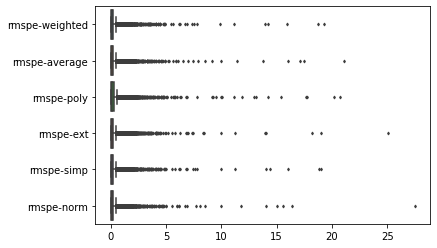

In [726]:
sns.boxplot(data=master[["rmspe-weighted",'rmspe-average','rmspe-poly',
                            'rmspe-ext', 'rmspe-simp', 'rmspe-norm']], orient="h", fliersize=2)

<AxesSubplot:>

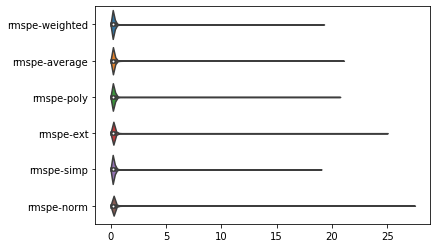

In [719]:
sns.violinplot(data=master[["rmspe-weighted",'rmspe-average','rmspe-poly',
                            'rmspe-ext', 'rmspe-simp', 'rmspe-norm']], orient="h", fliersize=0.1)

<AxesSubplot:>

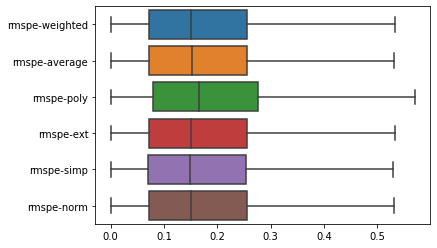

In [723]:
sns.boxplot(data=master[["rmspe-weighted",'rmspe-average','rmspe-poly',
                            'rmspe-ext', 'rmspe-simp', 'rmspe-norm']], orient="h", showfliers=False)

<AxesSubplot:xlabel='rmspe-weighted', ylabel='Count'>

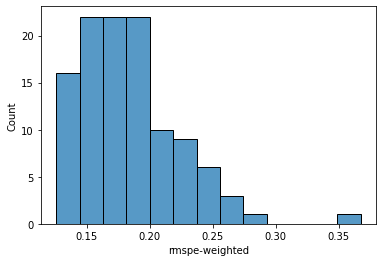

In [737]:
sns.histplot(master.groupby("stock_id")['rmspe-weighted'].mean())

<AxesSubplot:xlabel='rmspe-norm', ylabel='Count'>

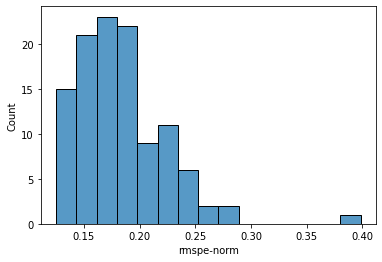

In [738]:
sns.histplot(master.groupby("stock_id")['rmspe-norm'].mean())

<AxesSubplot:xlabel='rmspe-ext', ylabel='Count'>

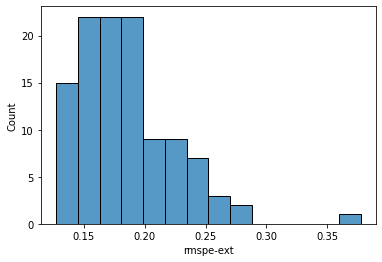

In [739]:
sns.histplot(master.groupby("stock_id")['rmspe-ext'].mean())

<AxesSubplot:xlabel='rmspe-simp', ylabel='Count'>

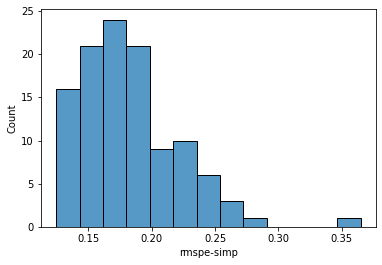

In [740]:
sns.histplot(master.groupby("stock_id")['rmspe-simp'].mean())

<AxesSubplot:xlabel='rmspe-poly', ylabel='Count'>

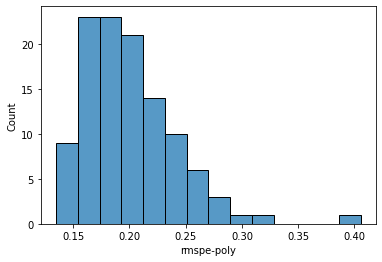

In [741]:
sns.histplot(master.groupby("stock_id")['rmspe-poly'].mean())

<AxesSubplot:xlabel='rmspe-average', ylabel='Count'>

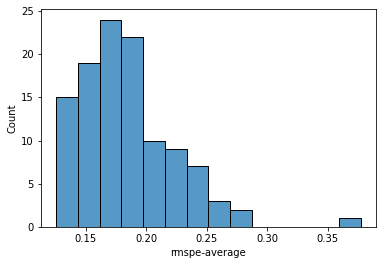

In [742]:
sns.histplot(master.groupby("stock_id")['rmspe-average'].mean())

In [743]:
master.describe()

,realized_volatility,lgbm-norm,time_id,stock_id,lgbm-simp,lgbm-ext,poly-reg,ensemble-average,ensemble-weighted,rmspe-weighted,rmspe-average,rmspe-poly,rmspe-ext,rmspe-simp,rmspe-norm
count,428931.000000,428931.000000,428931.000000,428931.000000,428931.000000,428931.000000,428931.000000,428931.000000,428931.000000,428931.000000,428931.000000,428931.000000,428931.000000,428931.000000,428931.000000
mean,0.002854,0.002537,16038.958725,62.438003,0.002539,0.002542,0.002463,0.002517,0.002521,0.184005,0.184780,0.200012,0.185046,0.183049,0.184048
std,0.002358,0.001872,9365.110137,37.126473,0.001869,0.001870,0.001862,0.001844,0.001857,0.172916,0.176602,0.194627,0.178876,0.174138,0.177311
min,0.000021,0.000150,5.000000,0.000000,0.000150,0.000150,-0.030429,-0.005941,0.000149,0.000000,0.000001,0.000000,0.000001,0.000003,0.000000
25%,0.001403,0.001315,7854.000000,30.000000,0.001316,0.001316,0.001301,0.001314,0.001306,0.072032,0.072655,0.080287,0.071882,0.070891,0.071555
50%,0.002160,0.001962,15853.000000,63.000000,0.001963,0.001965,0.001924,0.001953,0.001948,0.151556,0.151956,0.166148,0.151532,0.149697,0.150399
75%,0.003475,0.003118,23994.000000,96.000000,0.003117,0.003114,0.003008,0.003086,0.003095,0.256110,0.256159,0.276297,0.256437,0.254186,0.255512
max,0.065007,0.015133,32767.000000,126.000000,0.014701,0.014831,0.314321,0.113946,0.014593,19.262388,21.059015,20.723003,25.023422,19.025330,27.487513


In [751]:
df = master.drop(master.iloc[:,:9],axis=1)

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

IQR = Q3-Q1
outlier = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
outlier

rmspe-weighted    11066
rmspe-average     11565
rmspe-poly        11240
rmspe-ext         11720
rmspe-simp        11567
rmspe-norm        11667
dtype: int64

## Removing outliers

In [759]:
mask = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
df[mask] = np.nan

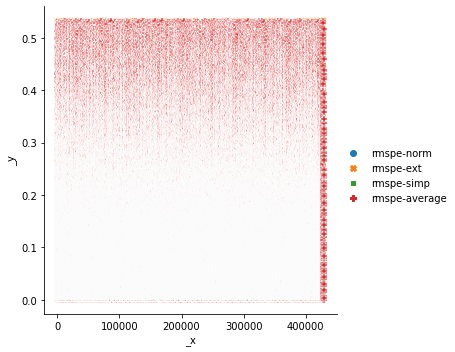

In [773]:
sns.relplot(data=df[['rmspe-norm','rmspe-ext', 'rmspe-simp', 'rmspe-average']])#, showfliers=False)

### Write Predictions to CSV

In [ ]:
test = test.astype({'time_id': int, 'stock_id': int})
test.to_csv("extend3.csv", index=False)
test

In [ ]:
test = pd.read_csv("extend3.csv")
test

## Model Feature Importance

In [ ]:
import seaborn as sns

def plot_importance(importance, title='', save_to_file=None, top=None):    
    importance = importance.sort_values(
        ['Importance'], ascending=False
    )[:top]#.sort_values(['Importance'])
    sns.set(font_scale=1)

    plt.figure(figsize=(10, 8))
    #importance.plot.barh(ax=ax)
    sns.barplot(x="Importance", y="Features", data=importance.sort_values(by="Importance",ascending=False))
    
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_to_file:
        plt.savefig(save_to_file)
    plt.show()
    plt.close()

def compute_mean_importance(importance):
    res = importance[0].copy()
    res['Importance'] = np.mean(np.array(
        [df['importance'].values for df in importance]
    ), axis=0)
    
    res = res.drop(['importance'], axis=1)
    
    # reformat for plot
    return pd.DataFrame(
        {'Features':[f for f in res.index], 
         'Importance': res['Importance']}
    ).reset_index(drop=True)


### Plotting Importance by Gain & Split

In [ ]:
mean_gain = compute_mean_importance(gain_importance)

plot_importance(mean_gain, title='Extend-3 Model: Top 40 Features by Gain', top=40,
               save_to_file="importance_by_gain_extend3.png")

mean_gain

In [ ]:
mean_gain = compute_mean_importance(split_importance)

plot_importance(mean_gain, title='Extend-3 Model: Top 40 Features by Split', top=40,
               save_to_file="importance_by_split_extend3.png")

mean_gain

In [ ]:
lgbm.plot_tree(models[0], tree_index = 0, figsize=(100,100))

## Post-Hoc ANOVA tests
https://statisticsbyjim.com/anova/post-hoc-tests-anova/ 

Every time we t-test the same data there is chance for a Type I error (i.e. reject null hypothesis when it is true), which is often the set significance level of 0.05. If we conduct multiple t-tests, Type I errors are accumulative. For two t-tests the chance for Type I error ~15% as seen in table below. Thus, we use ANOVA and post-hoc tests to control Type I error to always be 0.05 even with multiple comparisons.

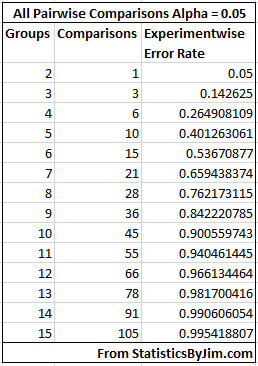

The experiment-wise error rate determines the probability of type I error (false positive) over a total family of comparisons. Our ANOVA example has 3 groups, which produces 3 comparisons and a family-wise error rate of 0.143. When performing statistical tests, we expect a false positive rate of 0.05 (our set significance level). As shown, when increasing groups from 2 to 3, the error rate is approximately tripled from 0.05 to 0.143. This introduces doubt as to whether we are observing a false positive as opposed to a significant difference.

If we use 2-sample t-tests to compare group means, and set a significance level of 0.05 for each test, then the number of comparisons will determine the experiment-wise error rate. In post hoc tests, we set an experiment-wise error rate for all comparisons, and the post hoc test calculates a significance level for individual comparisons to produce the specified familywise error rate.

In [ ]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import tukey_hsd

### ANOVA F-Test

    Null: All group means are equal.
    Alternative: Not all group means are equal.


In [ ]:
extend3 = test['rmspe-extend3']
extend2 = test['rmspe-extend2']
simple = test['rmspe-simple']

f_oneway(extend3, extend2, simple)

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.boxplot([extend3, extend2, simple], showfliers=False)
ax.set_xticklabels(["Extend-3", "Extend-2", "Simple"]) 
ax.set_ylabel("mean") 
plt.show()

Since p-val < 0.05, we have sufficient evidence that the mean values across each group are not equal.

### Tukey's Test

In [ ]:
result = tukey_hsd(extend3, extend2, simple)
print(result)

In [ ]:
tukey = pairwise_tukeyhsd(endog=df['score'],groups=df['group'],alpha=0.05)

In [ ]:
df = pd.DataFrame({'rmspe':list(extend3)+list(extend2)+list(simple),
                   'model':np.repeat(['extend3','extend2','simple'], repeats=len(extend3))})

tukey = pairwise_tukeyhsd(endog=df['rmspe'],groups=df['model'],alpha=0.05)
print(tukey)

* P-val for difference in means between extend2 and extend3: 0.9831
* P-val for difference in means between extend2 and simple: ~0
* P-val for difference in means between extend3 and simple: ~0

Thus, we would conclude there is a statistically significant difference between means of extend3 and simple models and extend2 and simple models, but not a statistically significant difference between means of extend3 and extend2 models.

In [ ]:
test_melt = pd.melt(test, value_vars=['rmspe-extend3', 'rmspe-extend2', 'rmspe-simple'])

test_melt.columns = ['model', 'value']
test_melt

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x='model', y='value', data=test_melt, color='#99c2a2', showfliers=False)

### Source: https://www.reneshbedre.com/blog/anova.html